In [8]:
import sys
import os
import importlib
import graphviz
import pm4py
from IPython.display import SVG, display, HTML, Image

# Ensure src path is available
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'simulator', 'src')))

from model.region import RegionModel
from converter.spin import from_region
import spin_visualizzation
# importlib.reload(svg_viz)  # Force reload to get latest changes
from spin_visualizzation import spin_to_svg


# Also reload converter
from converter import spin
importlib.reload(spin)

print("Imports successful! (modules reloaded)")

Imports successful! (modules reloaded)


# Interactive Scenario Explorer

Choose a pattern, then step through scenarios and toggle the visualizations.


In [10]:

import os
import sys
import copy

import graphviz
import ipywidgets as widgets
from IPython.display import display, SVG, clear_output

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'simulator', 'src')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'simulator', 'tests', 'spin')))

from patterns import get_patterns
from model.context import NetContext
from model.endpoints.execute.response import petri_net_to_dot
from model.region import RegionModel, RegionType
from model.status import ActivityState
from strategy.execution import get_choices
from strategy.time import TimeStrategy
from spin_visualizzation import spin_to_svg
from dot import wrap_to_dot


def _build_region_index(region_model: RegionModel) -> dict[int, RegionModel]:
    regions = {}

    def walk(node: RegionModel) -> None:
        try:
            node_id = int(node.id)
        except (TypeError, ValueError):
            node_id = node.id
        regions[node_id] = node
        if node.children:
            for child in node.children:
                walk(child)

    walk(region_model)
    regions[0] = region_model
    return regions


def _init_status(region_model: RegionModel) -> dict[RegionModel, ActivityState]:
    status = {}

    def walk(node: RegionModel) -> None:
        status[node] = ActivityState.WAITING
        if node.children:
            for child in node.children:
                walk(child)

    walk(region_model)
    return status


def _active_regions_from_marking(net, marking) -> set[str]:
    active = set()
    for place in net.places:
        entry_id = getattr(place, "entry_id", None)
        if entry_id is None:
            continue
        if marking[place].token > 0:
            active.add(str(entry_id))
    return active


def _build_visual_status_by_id(status: dict[RegionModel, ActivityState]) -> dict[str, int]:
    visual = {}
    for region, state in status.items():
        if region.is_task() and state in (
            ActivityState.ACTIVE,
            ActivityState.COMPLETED,
            ActivityState.COMPLETED_WITHOUT_PASSING_OVER,
        ):
            
            visual[str(region.id)] = int(state)
    return visual


def _select_loop_transition(place, transitions, marking):
    exit_transition = None
    loop_transition = None
    for transition in transitions:
        label = str(getattr(transition, "label", ""))
        if label.startswith("Exit"):
            exit_transition = transition
        elif label.startswith("Loop"):
            loop_transition = transition

    visit_limit = getattr(place, "visit_limit", None)
    if visit_limit is not None and marking[place].visit_count >= visit_limit:
        return exit_transition or transitions[0]

    return loop_transition or transitions[0]


def _choice_combinations(ctx, marking, branch_loops: bool) -> list[list]:
    choices_by_place = get_choices(ctx, marking)
    if not choices_by_place:
        return [[]]

    combos: list[list] = [[]]
    places = sorted(choices_by_place.keys(), key=lambda p: str(p.name))
    for place in places:
        transitions = sorted(choices_by_place[place], key=lambda t: str(t.name))
        region_type = transitions[0].region_type
        if region_type == RegionType.LOOP and not branch_loops:
            transitions = [_select_loop_transition(place, transitions, marking)]
        next_combos = []
        for combo in combos:
            for transition in transitions:
                next_combos.append(combo + [transition])
        combos = next_combos
    return combos


def _is_final(ctx, marking, final_marking) -> bool:
    if marking.tokens != final_marking.tokens:
        return False
    return len(ctx.semantic.enabled_transitions(ctx.net, marking)) == 0


def _display_dot(dot_source: str, label: str) -> None:
    try:
        display(graphviz.Source(dot_source))
    except Exception as exc:
        print(f"[{label}] Graphviz not available: {exc}")
        print(dot_source)


class ScenarioExplorer:
    def __init__(self, patterns, output):
        self.patterns = patterns
        self.pattern_map = {p["name"]: p for p in patterns}
        self.output = output
        self.show_bpmn = True
        self.show_spin = True
        self.show_petri = True
        self._reset_state()

    def _reset_state(self):
        self.pattern_name = None
        self.region_json = None
        self.region_model = None
        self.ctx = None
        self.regions = None
        self.time_strategy = None
        self.time_step = 1.0
        self.max_steps = 10
        self.branch_loops = False
        self.queue = []
        self.current = None
        self.next_scenario_id = 1

    def set_views(self, show_bpmn: bool, show_spin: bool, show_petri: bool, render: bool = True):
        self.show_bpmn = show_bpmn
        self.show_spin = show_spin
        self.show_petri = show_petri
        if render:
            self.render()

    def reset(self, pattern_name: str, time_step: float, max_steps: int, branch_loops: bool,
              show_bpmn: bool, show_spin: bool, show_petri: bool):
        self._reset_state()
        self.pattern_name = pattern_name
        self.time_step = time_step
        self.max_steps = max_steps
        self.branch_loops = branch_loops
        self.set_views(show_bpmn, show_spin, show_petri, render=False)

        pattern = self.pattern_map[pattern_name]
        self.region_json = copy.deepcopy(pattern["json"])
        self.region_model = RegionModel.model_validate(self.region_json)
        self.ctx = NetContext.from_region(self.region_model)
        self.regions = _build_region_index(self.region_model)
        self.time_strategy = TimeStrategy()

        self.queue.append({
            "id": self.next_scenario_id,
            "marking": self.ctx.initial_marking,
            "status": _init_status(self.region_model),
            "cumulative_time": 0.0,
            "steps": 0,
            "frame_index": 0,
        })
        self.next_scenario_id += 1
        self.next_scenario()

    def next_scenario(self):
        if not self.queue:
            self.render(message="No more scenarios in queue.")
            return
        self.current = self.queue.pop(0)
        self.render()

    def next_step(self):
        if self.current is None:
            self.render(message="No scenario loaded.")
            return

        if self.current["steps"] >= self.max_steps:
            self.render(message="Reached max steps for this scenario.")
            return

        if _is_final(self.ctx, self.current["marking"], self.ctx.final_marking):
            self.render(message="Scenario already at final marking.")
            return

        combos = _choice_combinations(self.ctx, self.current["marking"], self.branch_loops)
        if not combos:
            combos = [[]]

        first_state = None
        for idx, decisions in enumerate(combos):
            next_status = copy.deepcopy(self.current["status"])
            new_marking, probability, impacts, step_time, applied_decisions = self.time_strategy.consume(
                self.ctx,
                self.current["marking"],
                self.regions,
                next_status,
                self.time_step,
                decisions,
            )
            if step_time == 0 and new_marking == self.current["marking"]:
                continue

            next_state = {
                "id": self.current["id"] if idx == 0 else self.next_scenario_id,
                "marking": new_marking,
                "status": next_status,
                "cumulative_time": self.current["cumulative_time"] + step_time,
                "steps": self.current["steps"] + 1,
                "frame_index": self.current["frame_index"] + 1,
            }

            if idx == 0:
                first_state = next_state
            else:
                self.queue.append(next_state)
                self.next_scenario_id += 1

        if first_state is None:
            self.render(message="No progress possible from this state.")
            return

        self.current = first_state
        self.render()

    def render(self, message: str | None = None):
        with self.output:
            clear_output()
            if message:
                print(message)
                print()

            if self.current is None:
                print("No scenario loaded.")
                return

            print(f"Pattern: {self.pattern_name}")
            print(f"Scenario: {self.current['id']} | Step: {self.current['steps']} / {self.max_steps} | Time: {self.current['cumulative_time']}")
            print(f"Queue length: {len(self.queue)}")
            print()

            marking = self.current["marking"]
            status_by_id = _build_visual_status_by_id(self.current["status"])
            active_regions = _active_regions_from_marking(self.ctx.net, marking)

            if self.show_bpmn:
                bpmn_dot = wrap_to_dot(
                    self.region_json,
                    impacts_names=["I1"],
                    active_regions=active_regions,
                    status_by_id=status_by_id,
                )
                _display_dot(bpmn_dot, "BPMN")

            if self.show_spin:
                spin_svg = spin_to_svg(self.ctx.net, width=1000, height=500, region=self.region_model, marking=marking)
                display(SVG(spin_svg))

            if self.show_petri:
                petri_dot = petri_net_to_dot(self.ctx.net, marking, self.ctx.final_marking)
                _display_dot(petri_dot, "Petri net")


patterns = get_patterns()
pattern_names = [p["name"] for p in patterns]
output = widgets.Output()
explorer = ScenarioExplorer(patterns, output)

pattern_dropdown = widgets.Dropdown(options=pattern_names, description="Pattern")
time_step_input = widgets.FloatText(value=1.0, description="Time step")
max_steps_input = widgets.IntText(value=10, description="Max steps")
branch_loops_cb = widgets.Checkbox(value=False, description="Branch loops")

show_bpmn_cb = widgets.Checkbox(value=True, description="BPMN")
show_spin_cb = widgets.Checkbox(value=True, description="SPIN")
show_petri_cb = widgets.Checkbox(value=True, description="Petri net")

reset_btn = widgets.Button(description="Reset", button_style="primary")
next_step_btn = widgets.Button(description="Next step")
next_scenario_btn = widgets.Button(description="Next scenario")


def _handle_reset(_):
    explorer.reset(
        pattern_dropdown.value,
        time_step_input.value,
        max_steps_input.value,
        branch_loops_cb.value,
        show_bpmn_cb.value,
        show_spin_cb.value,
        show_petri_cb.value,
    )


def _handle_next_step(_):
    explorer.next_step()


def _handle_next_scenario(_):
    explorer.next_scenario()


def _handle_view_change(_):
    explorer.set_views(show_bpmn_cb.value, show_spin_cb.value, show_petri_cb.value)


reset_btn.on_click(_handle_reset)
next_step_btn.on_click(_handle_next_step)
next_scenario_btn.on_click(_handle_next_scenario)

show_bpmn_cb.observe(_handle_view_change, names="value")
show_spin_cb.observe(_handle_view_change, names="value")
show_petri_cb.observe(_handle_view_change, names="value")

controls_row1 = widgets.HBox([pattern_dropdown, time_step_input, max_steps_input, branch_loops_cb])
controls_row2 = widgets.HBox([show_bpmn_cb, show_spin_cb, show_petri_cb])
controls_row3 = widgets.HBox([reset_btn, next_step_btn, next_scenario_btn])

ui = widgets.VBox([controls_row1, controls_row2, controls_row3, output])
display(ui)

_handle_reset(None)


2026-01-20 18:23:12 - INFO - Starting conversion from BPMN to Petri net


## Single Task
**Expression**: `R1`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


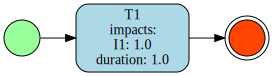


=== Petri Net (PM4PY Standard) ===


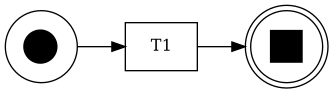


=== SPIN Visualization (Custom SVG) ===


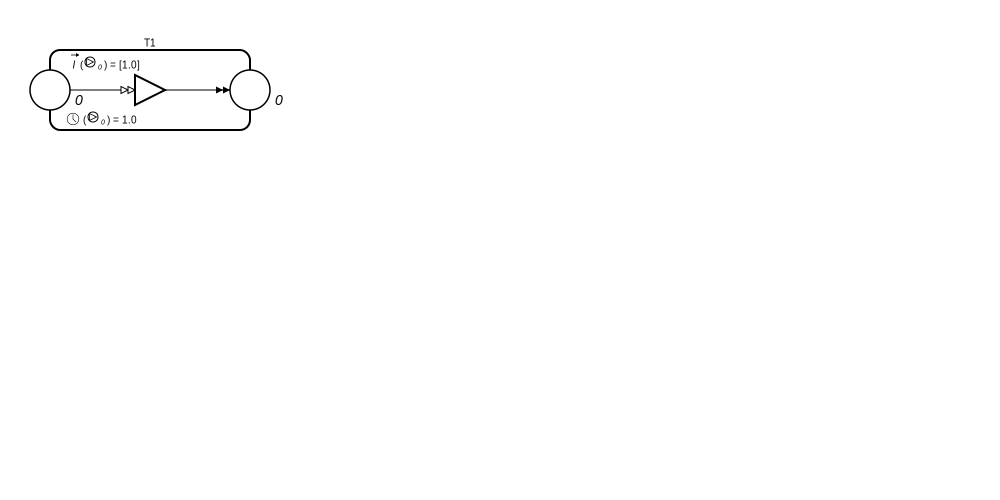

In [21]:
# Expression: R1
region_json = {
    "id": "0",
    "type": "task",
    "label": "T1",
    "duration": 1.0,
    "impacts": [
        1.0
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequence Two
**Expression**: `R1, R2`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


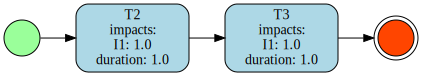


=== Petri Net (PM4PY Standard) ===


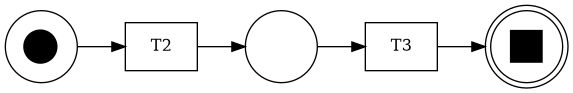


=== SPIN Visualization (Custom SVG) ===


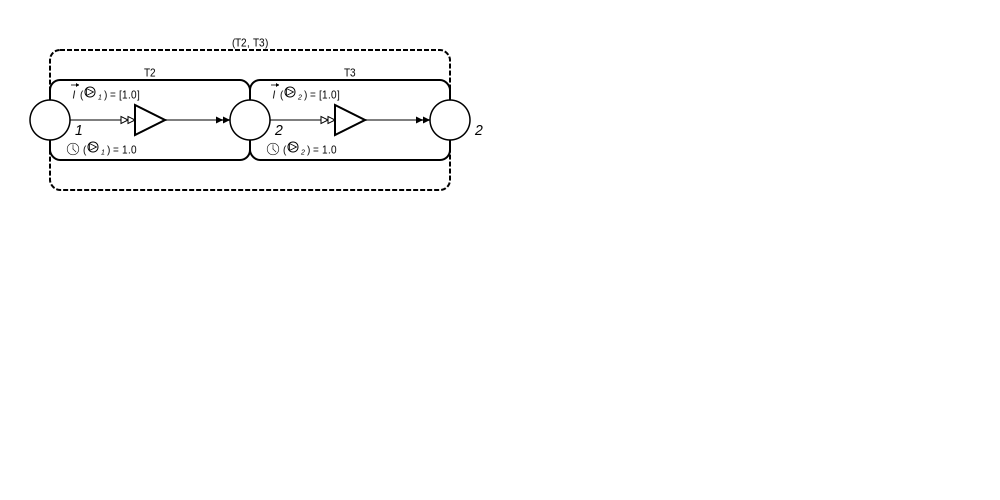

In [22]:
# Expression: R1, R2
region_json = {
    "id": "3",
    "type": "sequential",
    "children": [
        {
            "id": "1",
            "type": "task",
            "label": "T2",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "2",
            "type": "task",
            "label": "T3",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Choice
**Expression**: `R1 /[C1] R2`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


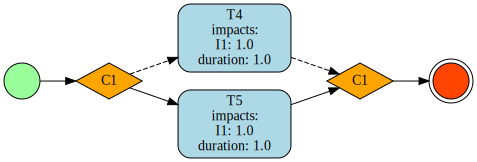


=== Petri Net (PM4PY Standard) ===


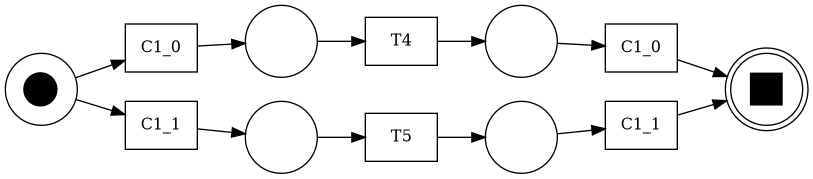


=== SPIN Visualization (Custom SVG) ===


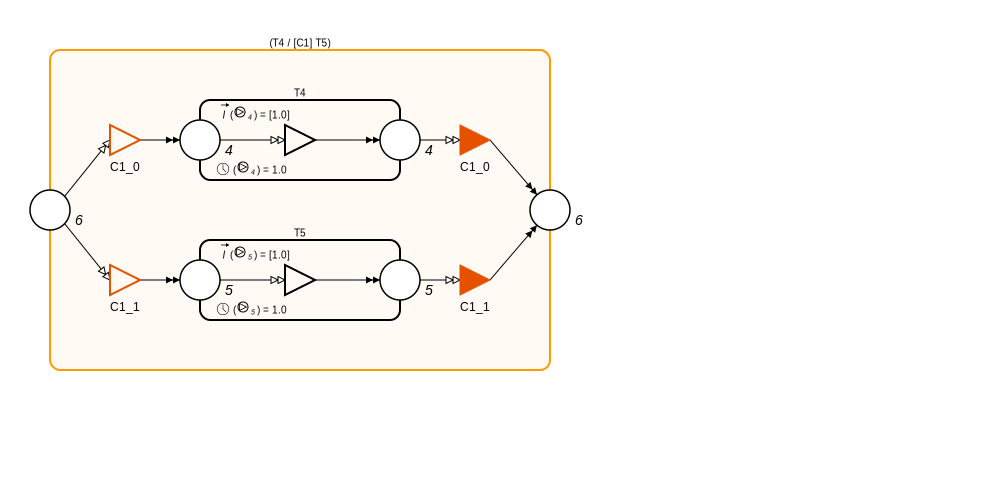

In [23]:
# Expression: R1 /[C1] R2
region_json = {
    "id": "6",
    "type": "choice",
    "label": "C1",
    "children": [
        {
            "id": "4",
            "type": "task",
            "label": "T4",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "5",
            "type": "task",
            "label": "T5",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel
**Expression**: `R1 || R2`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


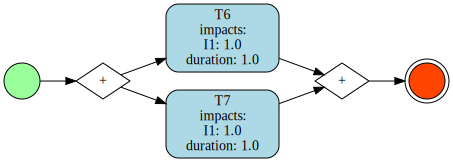


=== Petri Net (PM4PY Standard) ===


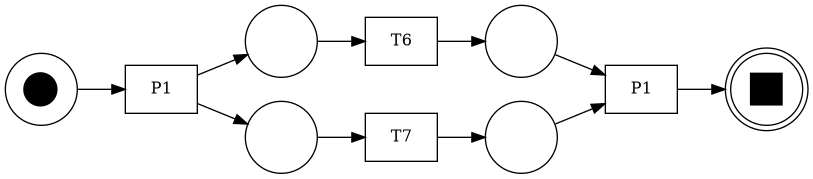


=== SPIN Visualization (Custom SVG) ===


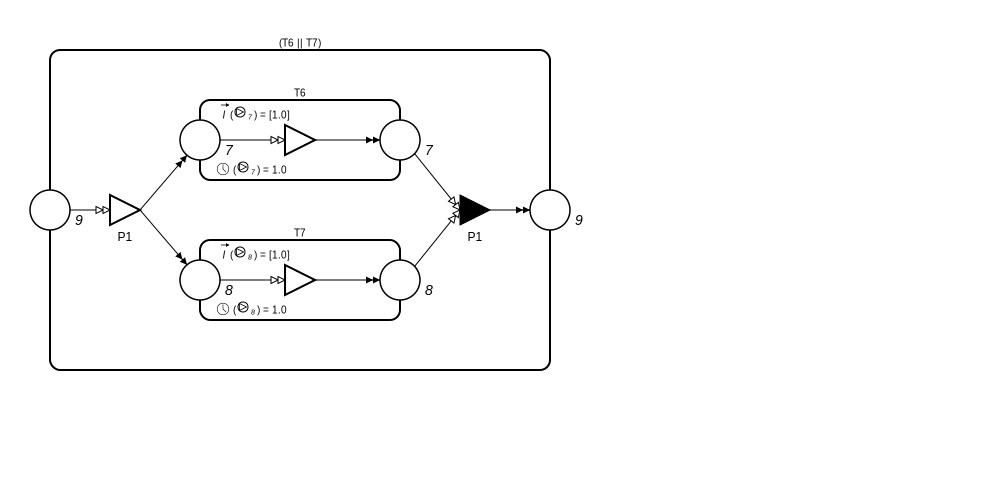

In [24]:
# Expression: R1 || R2
region_json = {
    "id": "9",
    "type": "parallel",
    "label": "P1",
    "children": [
        {
            "id": "7",
            "type": "task",
            "label": "T6",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "8",
            "type": "task",
            "label": "T7",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Loop
**Expression**: `<R1 [L1]>`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


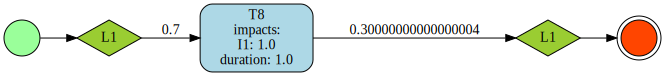


=== Petri Net (PM4PY Standard) ===


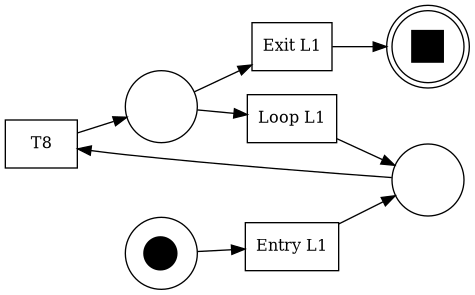


=== SPIN Visualization (Custom SVG) ===


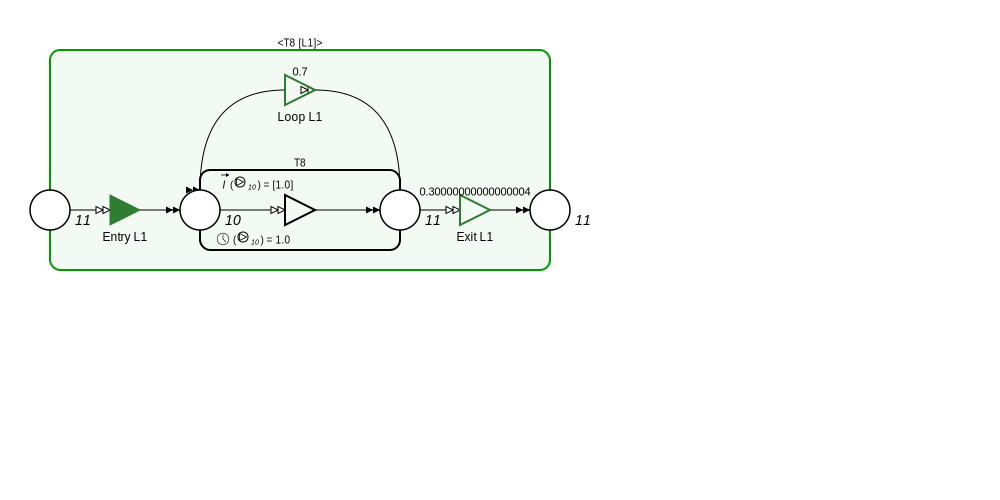

In [25]:
# Expression: <R1 [L1]>
region_json = {
    "id": "11",
    "type": "loop",
    "label": "L1",
    "children": [
        {
            "id": "10",
            "type": "task",
            "label": "T8",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": 0.7,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nature
**Expression**: `^[N1] (R1, R2)`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


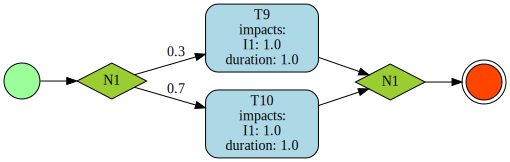


=== Petri Net (PM4PY Standard) ===


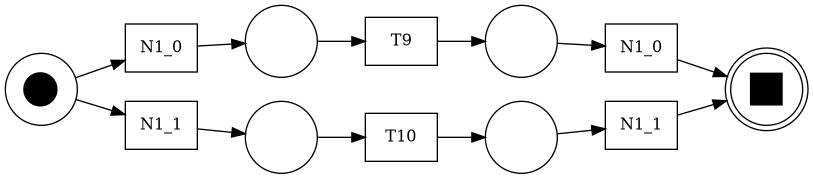


=== SPIN Visualization (Custom SVG) ===


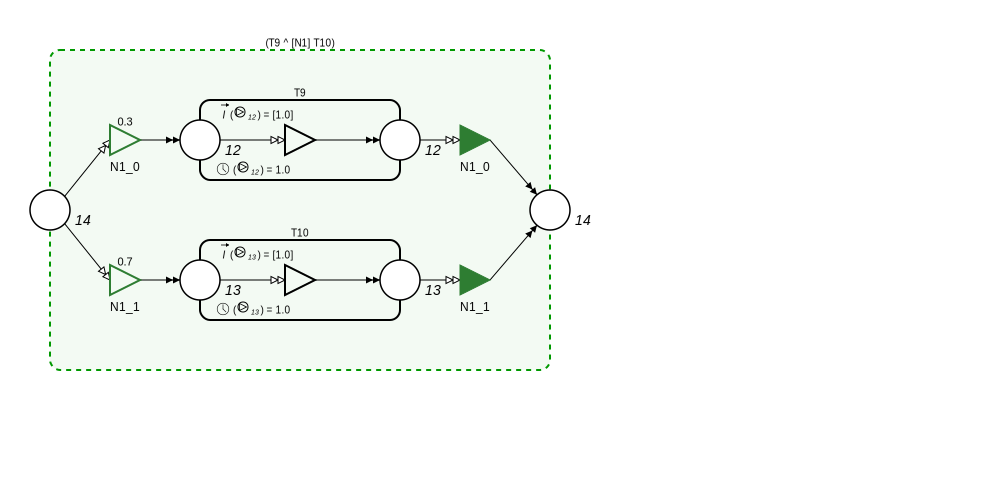

In [26]:
# Expression: ^[N1] (R1, R2)
region_json = {
    "id": "14",
    "type": "nature",
    "label": "N1",
    "children": [
        {
            "id": "12",
            "type": "task",
            "label": "T9",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "13",
            "type": "task",
            "label": "T10",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.3,
        0.7
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequential + Parallel
**Expression**: `R1, (R2 || R3), R4`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


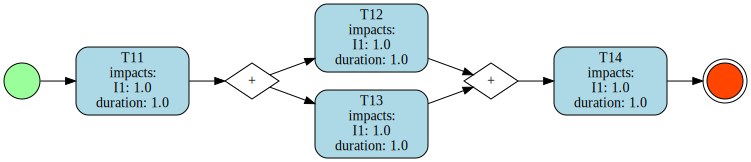


=== Petri Net (PM4PY Standard) ===


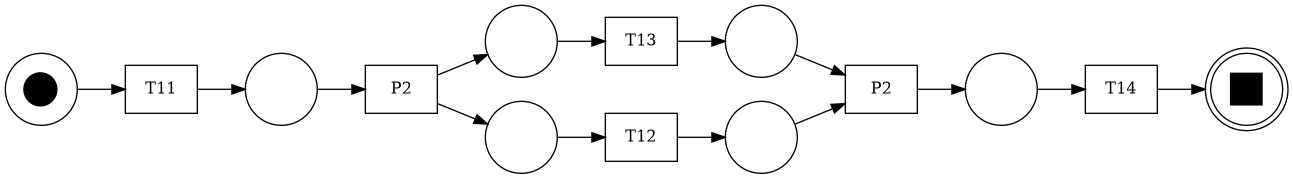


=== SPIN Visualization (Custom SVG) ===


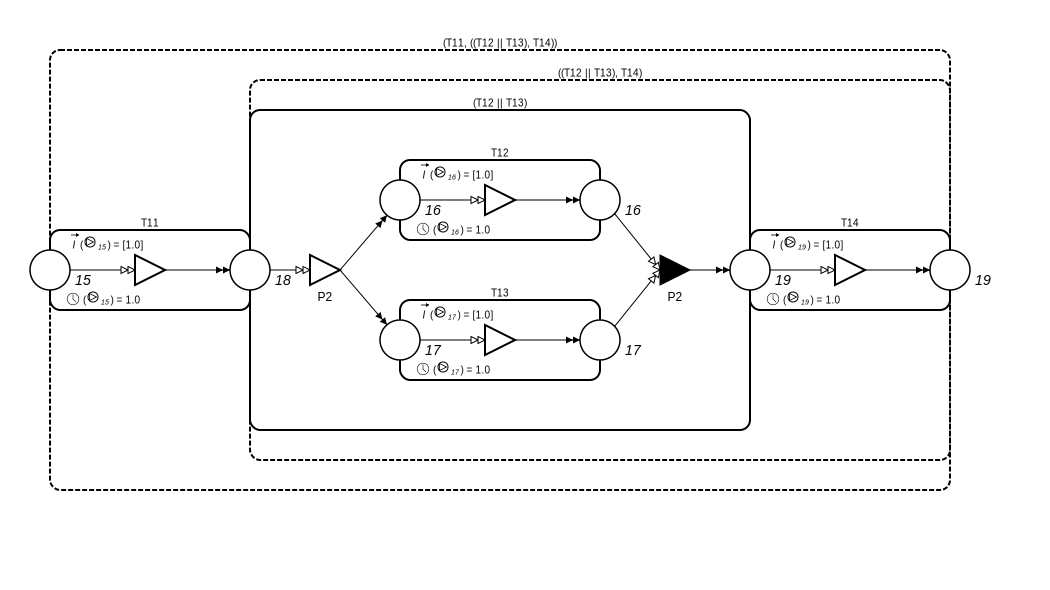

In [27]:
# Expression: R1, (R2 || R3), R4
region_json = {
    "id": "21",
    "type": "sequential",
    "children": [
        {
            "id": "15",
            "type": "task",
            "label": "T11",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "20",
            "type": "sequential",
            "children": [
                {
                    "id": "18",
                    "type": "parallel",
                    "label": "P2",
                    "children": [
                        {
                            "id": "16",
                            "type": "task",
                            "label": "T12",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        },
                        {
                            "id": "17",
                            "type": "task",
                            "label": "T13",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ]
                },
                {
                    "id": "19",
                    "type": "task",
                    "label": "T14",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequential + Choice
**Expression**: `R1, (R2 /[C1] R3), R4`

2026-01-20 13:56:58 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


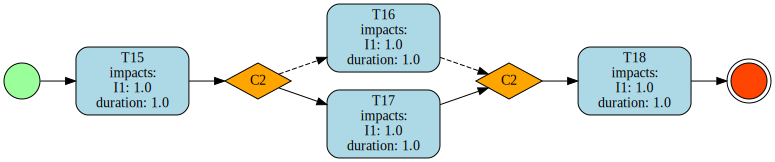


=== Petri Net (PM4PY Standard) ===


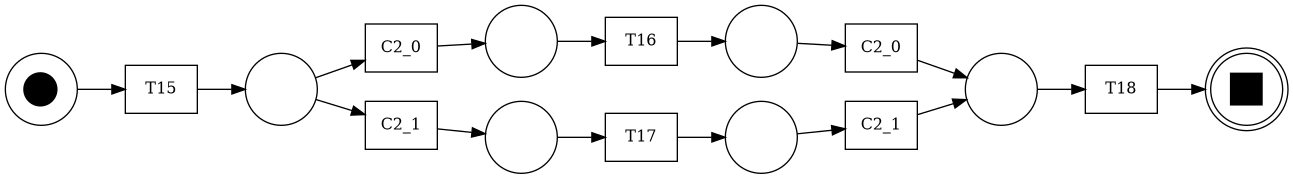


=== SPIN Visualization (Custom SVG) ===


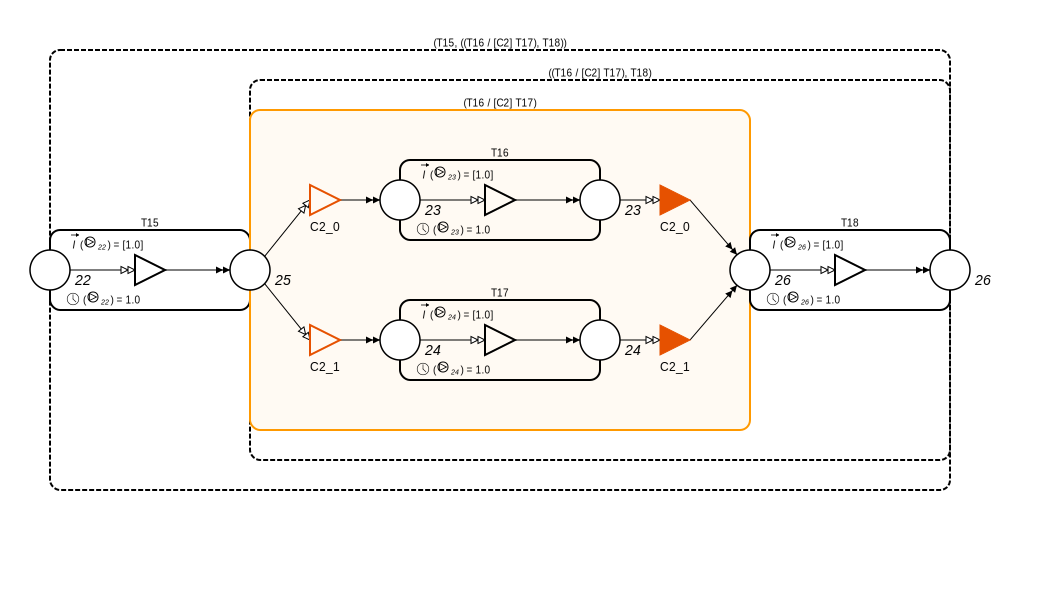

In [28]:
# Expression: R1, (R2 /[C1] R3), R4
region_json = {
    "id": "28",
    "type": "sequential",
    "children": [
        {
            "id": "22",
            "type": "task",
            "label": "T15",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "27",
            "type": "sequential",
            "children": [
                {
                    "id": "25",
                    "type": "choice",
                    "label": "C2",
                    "children": [
                        {
                            "id": "23",
                            "type": "task",
                            "label": "T16",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        },
                        {
                            "id": "24",
                            "type": "task",
                            "label": "T17",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ],
                    "max_delay": 0.0
                },
                {
                    "id": "26",
                    "type": "task",
                    "label": "T18",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequential + Loop
**Expression**: `R1, <R2 [L1]>, R3`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


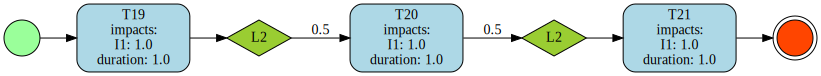


=== Petri Net (PM4PY Standard) ===


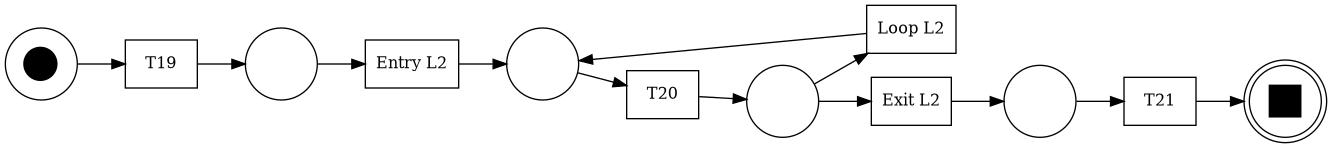


=== SPIN Visualization (Custom SVG) ===


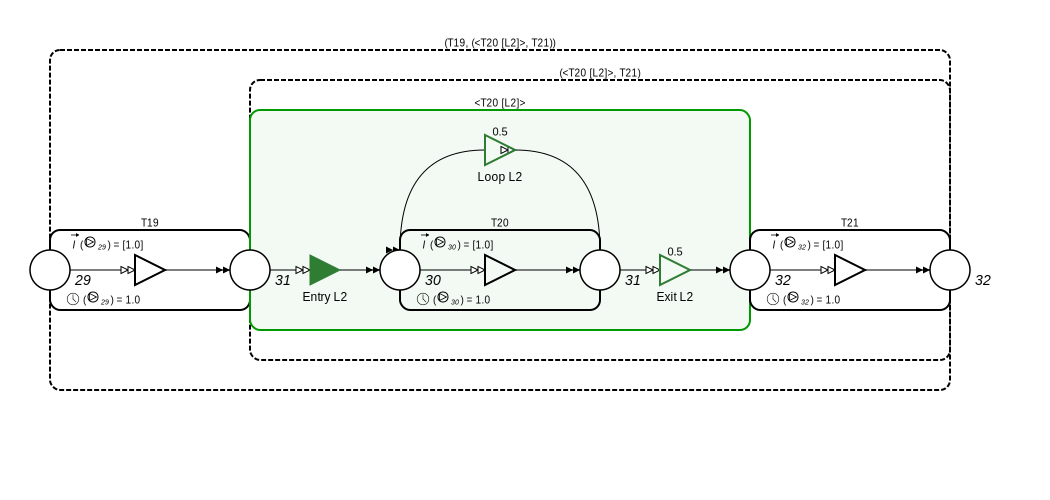

In [29]:
# Expression: R1, <R2 [L1]>, R3
region_json = {
    "id": "34",
    "type": "sequential",
    "children": [
        {
            "id": "29",
            "type": "task",
            "label": "T19",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "33",
            "type": "sequential",
            "children": [
                {
                    "id": "31",
                    "type": "loop",
                    "label": "L2",
                    "children": [
                        {
                            "id": "30",
                            "type": "task",
                            "label": "T20",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ],
                    "distribution": 0.5,
                    "bound": 5
                },
                {
                    "id": "32",
                    "type": "task",
                    "label": "T21",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequential + Nature
**Expression**: `R1, ^[N1] (R2, R3), R4`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


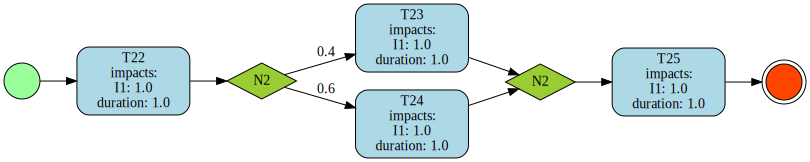


=== Petri Net (PM4PY Standard) ===


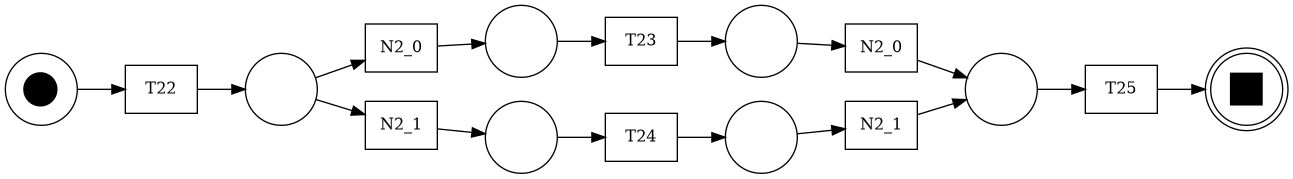


=== SPIN Visualization (Custom SVG) ===


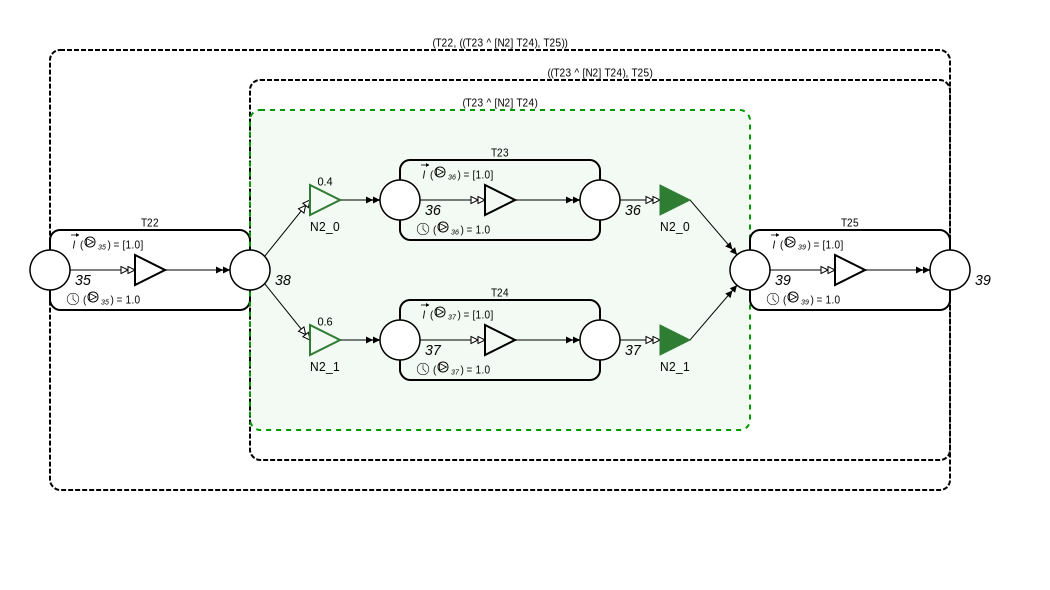

In [30]:
# Expression: R1, ^[N1] (R2, R3), R4
region_json = {
    "id": "41",
    "type": "sequential",
    "children": [
        {
            "id": "35",
            "type": "task",
            "label": "T22",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "40",
            "type": "sequential",
            "children": [
                {
                    "id": "38",
                    "type": "nature",
                    "label": "N2",
                    "children": [
                        {
                            "id": "36",
                            "type": "task",
                            "label": "T23",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        },
                        {
                            "id": "37",
                            "type": "task",
                            "label": "T24",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ],
                    "distribution": [
                        0.4,
                        0.6
                    ]
                },
                {
                    "id": "39",
                    "type": "task",
                    "label": "T25",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Complex Parallel
**Expression**: `R1, ((R2 /[C1] R3) || <R4 [L1]>), R5`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


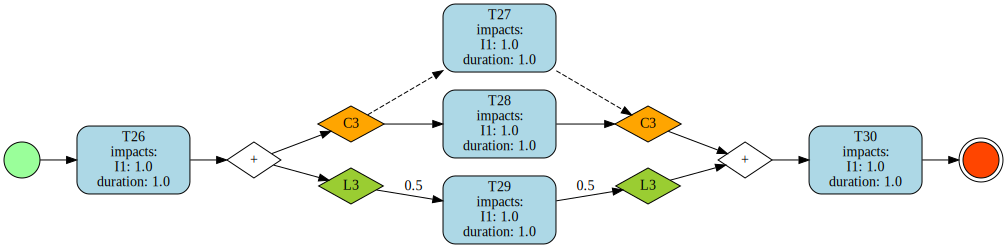


=== Petri Net (PM4PY Standard) ===


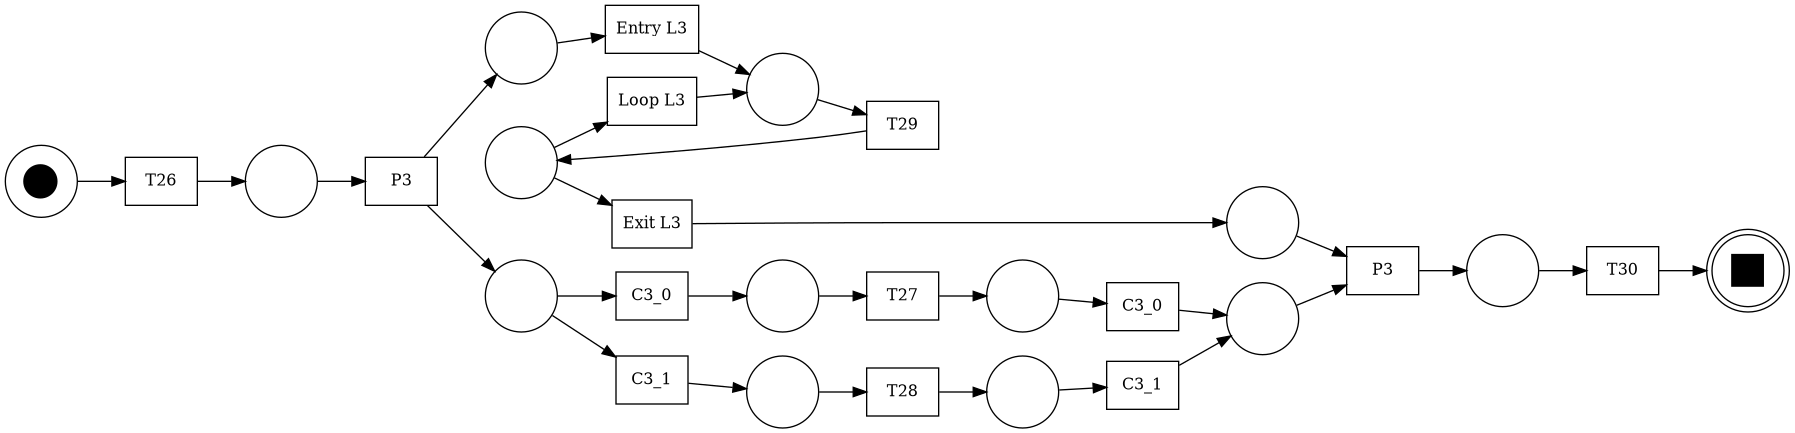


=== SPIN Visualization (Custom SVG) ===


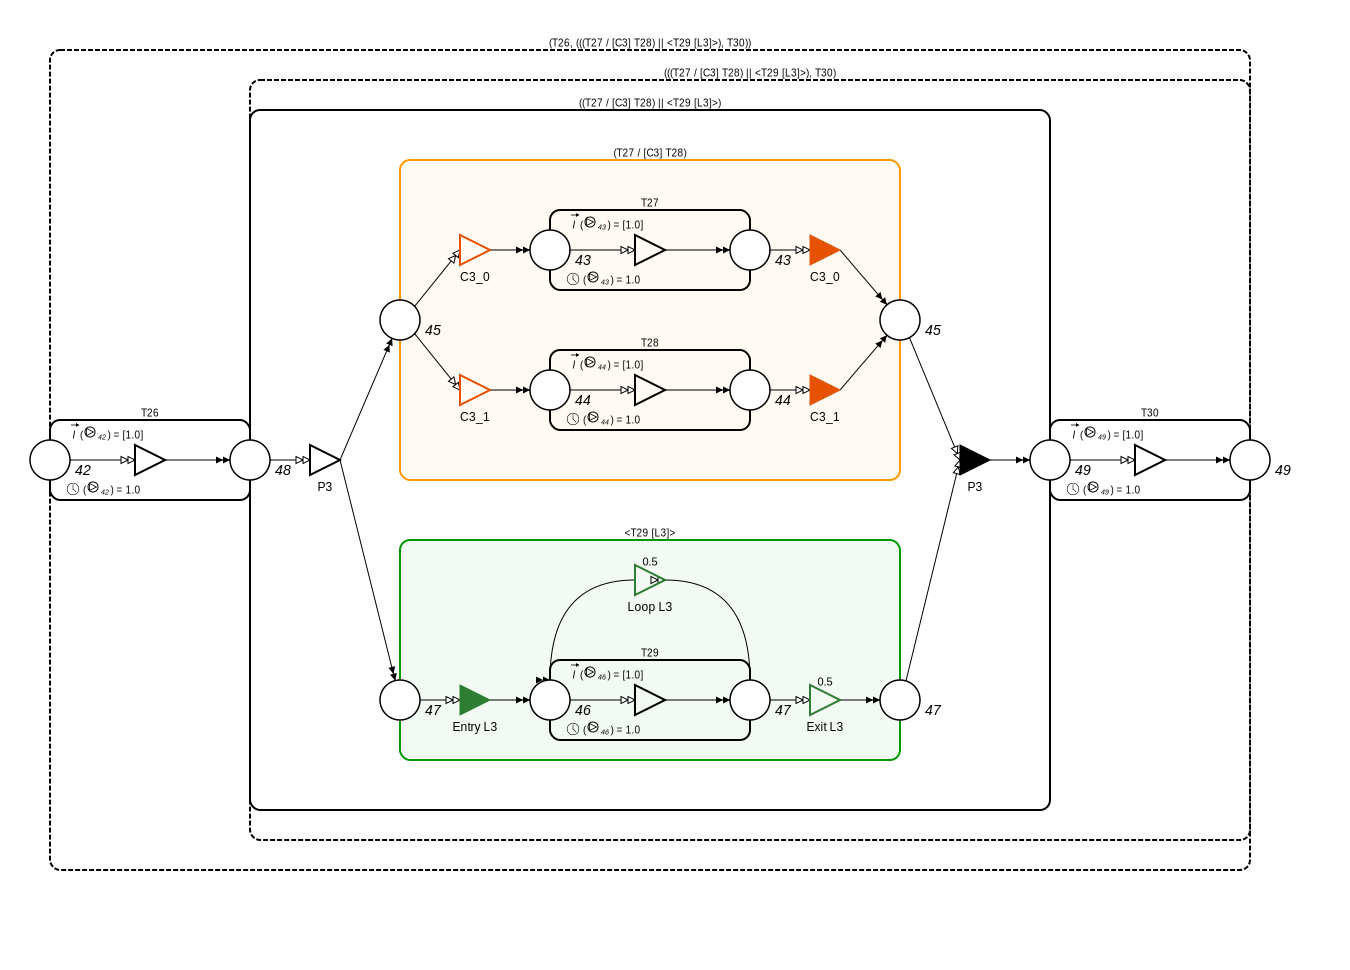

In [31]:
# Expression: R1, ((R2 /[C1] R3) || <R4 [L1]>), R5
region_json = {
    "id": "51",
    "type": "sequential",
    "children": [
        {
            "id": "42",
            "type": "task",
            "label": "T26",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "50",
            "type": "sequential",
            "children": [
                {
                    "id": "48",
                    "type": "parallel",
                    "label": "P3",
                    "children": [
                        {
                            "id": "45",
                            "type": "choice",
                            "label": "C3",
                            "children": [
                                {
                                    "id": "43",
                                    "type": "task",
                                    "label": "T27",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                },
                                {
                                    "id": "44",
                                    "type": "task",
                                    "label": "T28",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                }
                            ],
                            "max_delay": 0.0
                        },
                        {
                            "id": "47",
                            "type": "loop",
                            "label": "L3",
                            "children": [
                                {
                                    "id": "46",
                                    "type": "task",
                                    "label": "T29",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                }
                            ],
                            "distribution": 0.5,
                            "bound": 5
                        }
                    ]
                },
                {
                    "id": "49",
                    "type": "task",
                    "label": "T30",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel Choice Simple
**Expression**: `((R2 /[C1] R3) || R4)`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


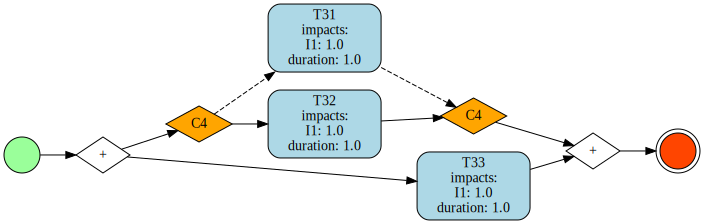


=== Petri Net (PM4PY Standard) ===


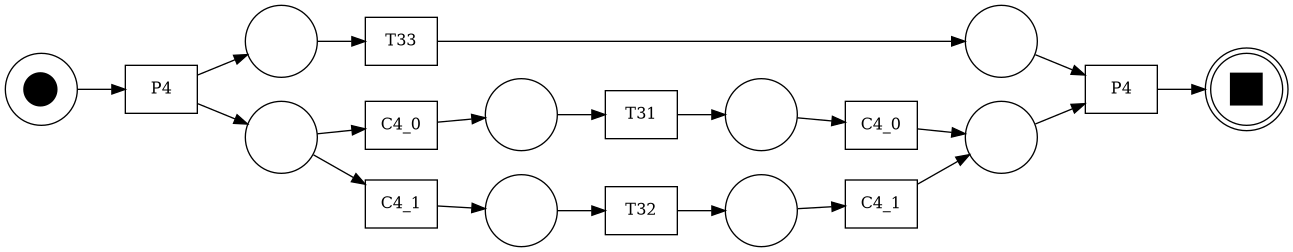


=== SPIN Visualization (Custom SVG) ===


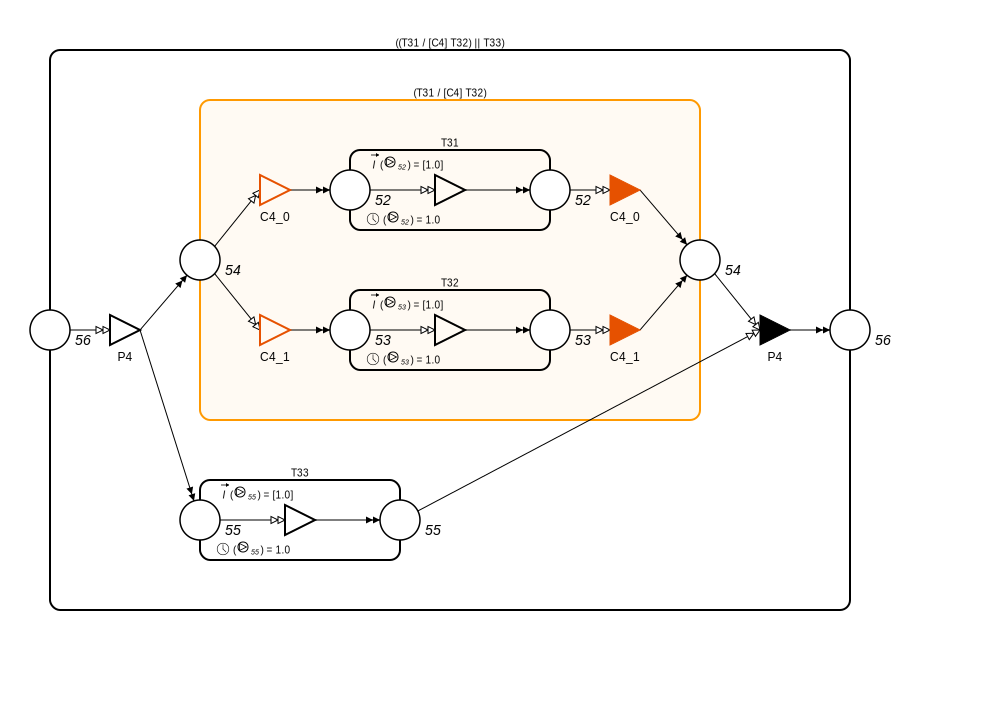

In [32]:
# Expression: ((R2 /[C1] R3) || R4)
region_json = {
    "id": "56",
    "type": "parallel",
    "label": "P4",
    "children": [
        {
            "id": "54",
            "type": "choice",
            "label": "C4",
            "children": [
                {
                    "id": "52",
                    "type": "task",
                    "label": "T31",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "53",
                    "type": "task",
                    "label": "T32",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "max_delay": 0.0
        },
        {
            "id": "55",
            "type": "task",
            "label": "T33",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Choice of Parallels
**Expression**: `(R1 || R2) /[C1] (R3 || R4)`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


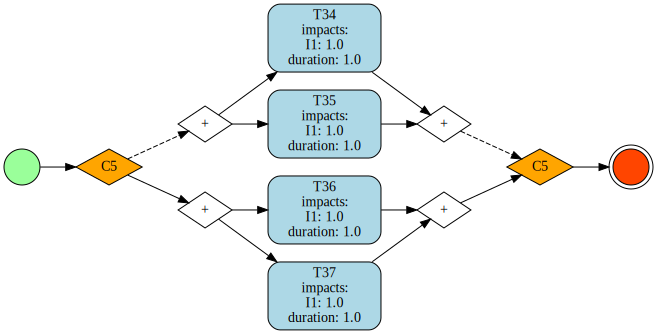


=== Petri Net (PM4PY Standard) ===


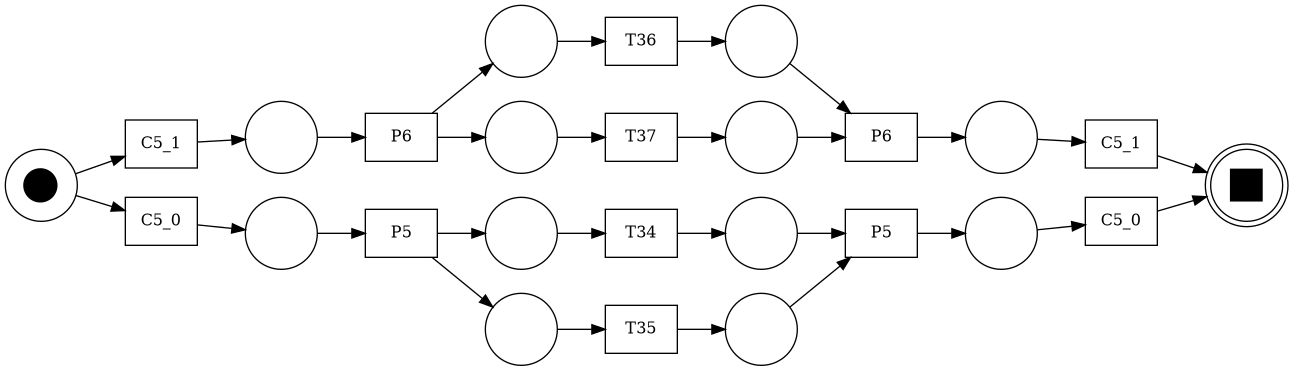


=== SPIN Visualization (Custom SVG) ===


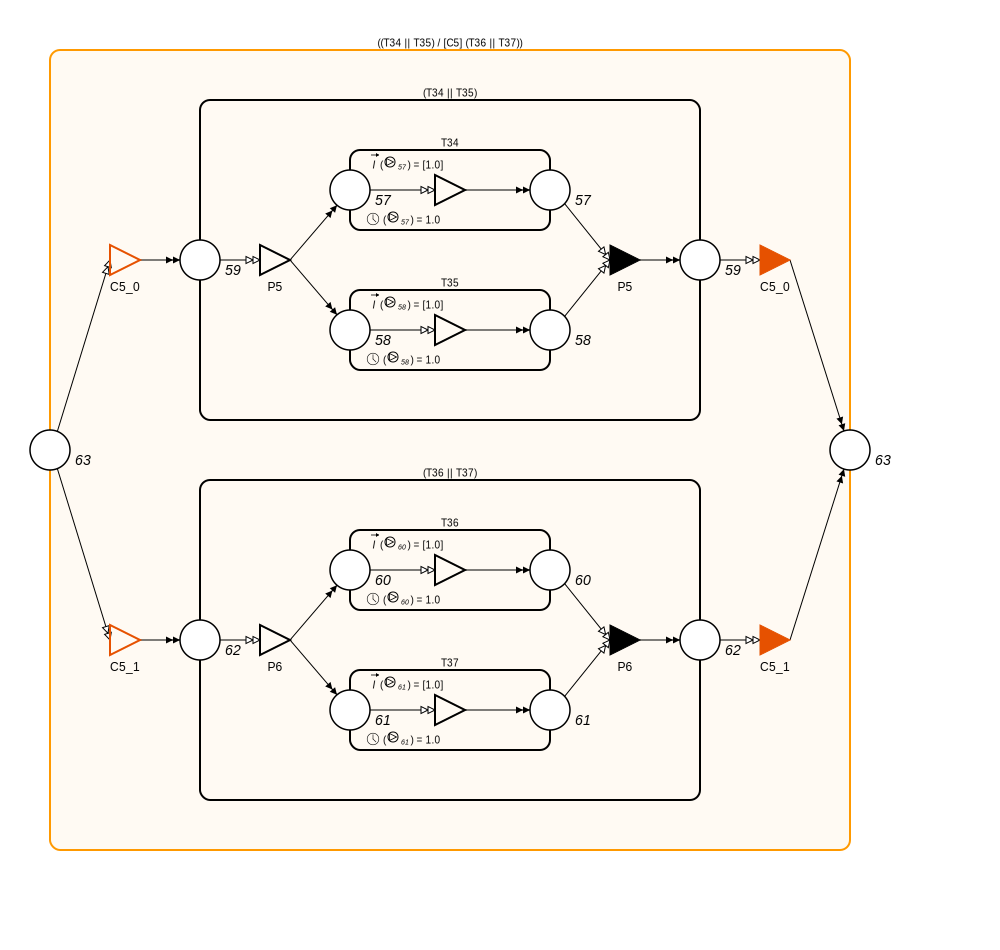

In [33]:
# Expression: (R1 || R2) /[C1] (R3 || R4)
region_json = {
    "id": "63",
    "type": "choice",
    "label": "C5",
    "children": [
        {
            "id": "59",
            "type": "parallel",
            "label": "P5",
            "children": [
                {
                    "id": "57",
                    "type": "task",
                    "label": "T34",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "58",
                    "type": "task",
                    "label": "T35",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "62",
            "type": "parallel",
            "label": "P6",
            "children": [
                {
                    "id": "60",
                    "type": "task",
                    "label": "T36",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "61",
                    "type": "task",
                    "label": "T37",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel with Loop
**Expression**: `R1 || <R2 [L1]>`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


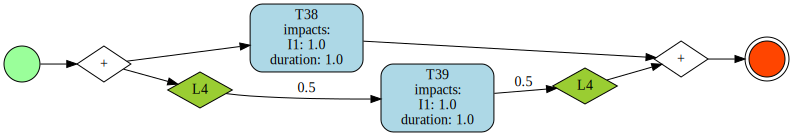


=== Petri Net (PM4PY Standard) ===


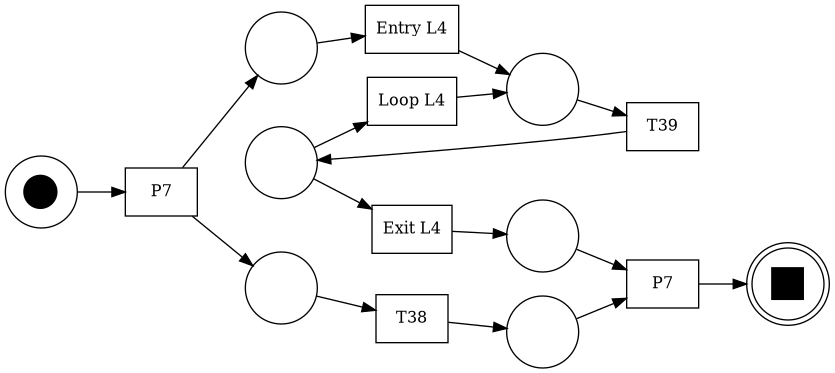


=== SPIN Visualization (Custom SVG) ===


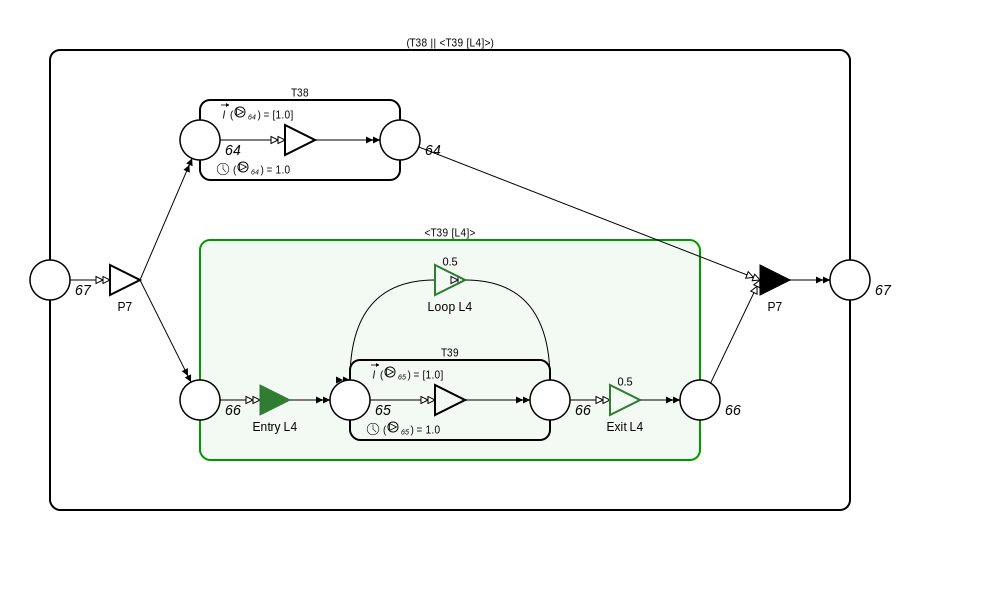

In [34]:
# Expression: R1 || <R2 [L1]>
region_json = {
    "id": "67",
    "type": "parallel",
    "label": "P7",
    "children": [
        {
            "id": "64",
            "type": "task",
            "label": "T38",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "66",
            "type": "loop",
            "label": "L4",
            "children": [
                {
                    "id": "65",
                    "type": "task",
                    "label": "T39",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": 0.5,
            "bound": 5
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Sequential in Parallel
**Expression**: `(R1, R2) || (R3, R4)`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


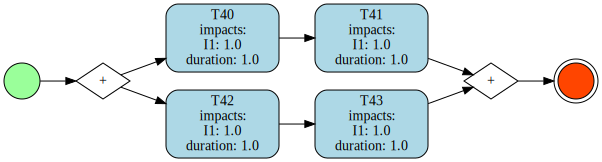


=== Petri Net (PM4PY Standard) ===


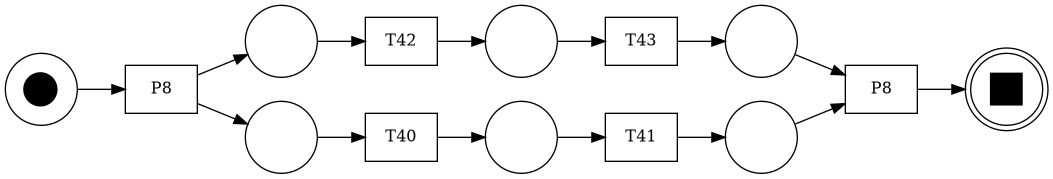


=== SPIN Visualization (Custom SVG) ===


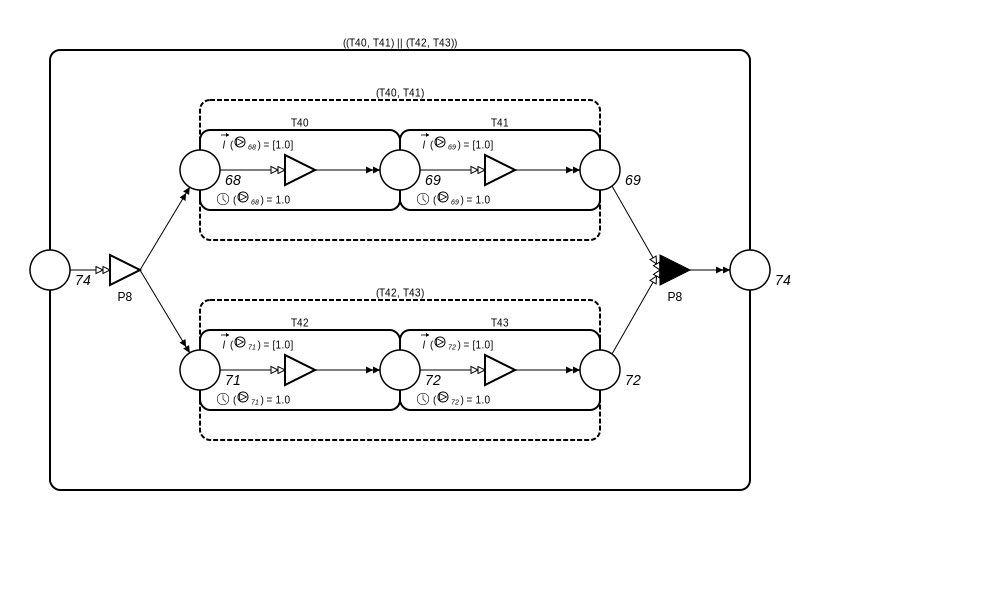

In [35]:
# Expression: (R1, R2) || (R3, R4)
region_json = {
    "id": "74",
    "type": "parallel",
    "label": "P8",
    "children": [
        {
            "id": "70",
            "type": "sequential",
            "children": [
                {
                    "id": "68",
                    "type": "task",
                    "label": "T40",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "69",
                    "type": "task",
                    "label": "T41",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "73",
            "type": "sequential",
            "children": [
                {
                    "id": "71",
                    "type": "task",
                    "label": "T42",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "72",
                    "type": "task",
                    "label": "T43",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nested Choice
**Expression**: `(R1 /[C1] R2) /[C2] R3`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


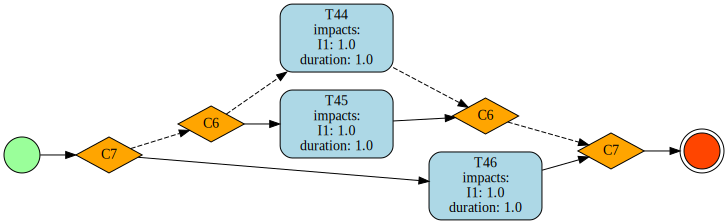


=== Petri Net (PM4PY Standard) ===


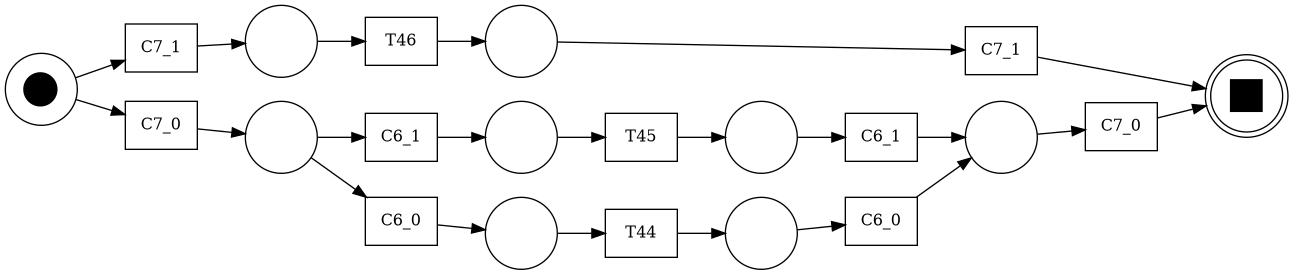


=== SPIN Visualization (Custom SVG) ===


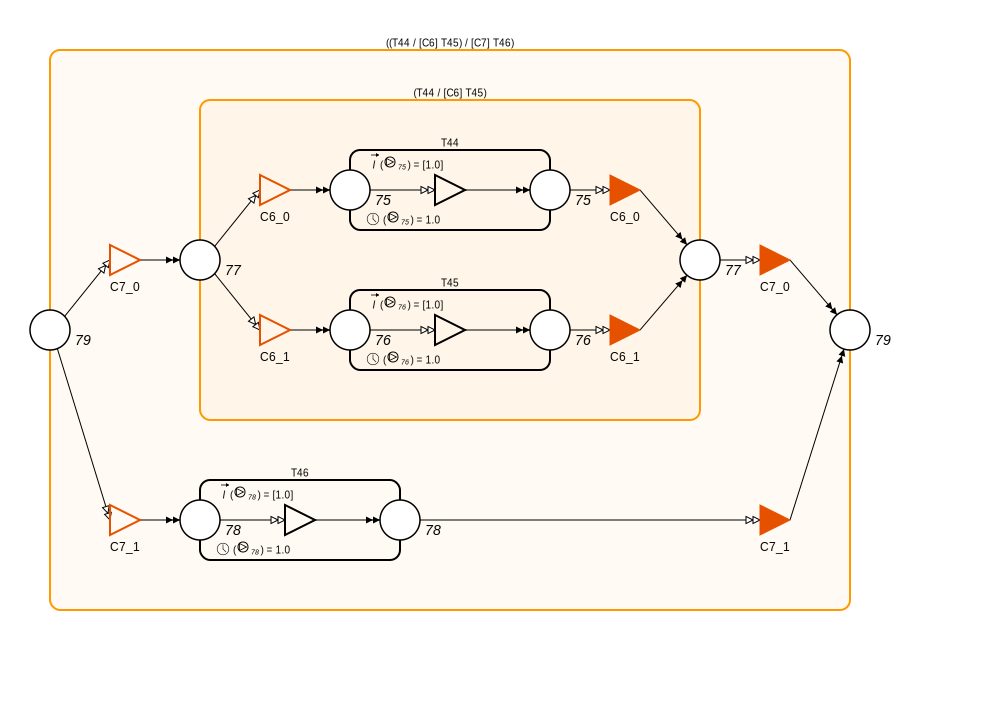

In [36]:
# Expression: (R1 /[C1] R2) /[C2] R3
region_json = {
    "id": "79",
    "type": "choice",
    "label": "C7",
    "children": [
        {
            "id": "77",
            "type": "choice",
            "label": "C6",
            "children": [
                {
                    "id": "75",
                    "type": "task",
                    "label": "T44",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "76",
                    "type": "task",
                    "label": "T45",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "max_delay": 0.0
        },
        {
            "id": "78",
            "type": "task",
            "label": "T46",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Loop containing Parallel
**Expression**: `<(R1 || R2) [L1]>`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


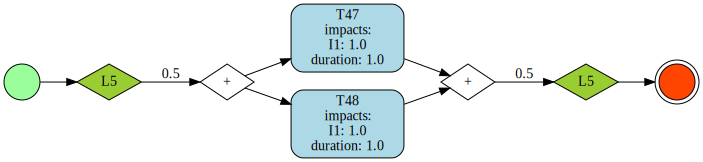


=== Petri Net (PM4PY Standard) ===


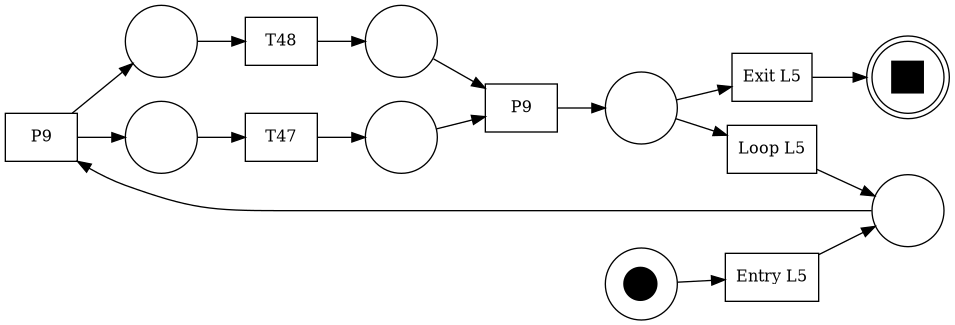


=== SPIN Visualization (Custom SVG) ===


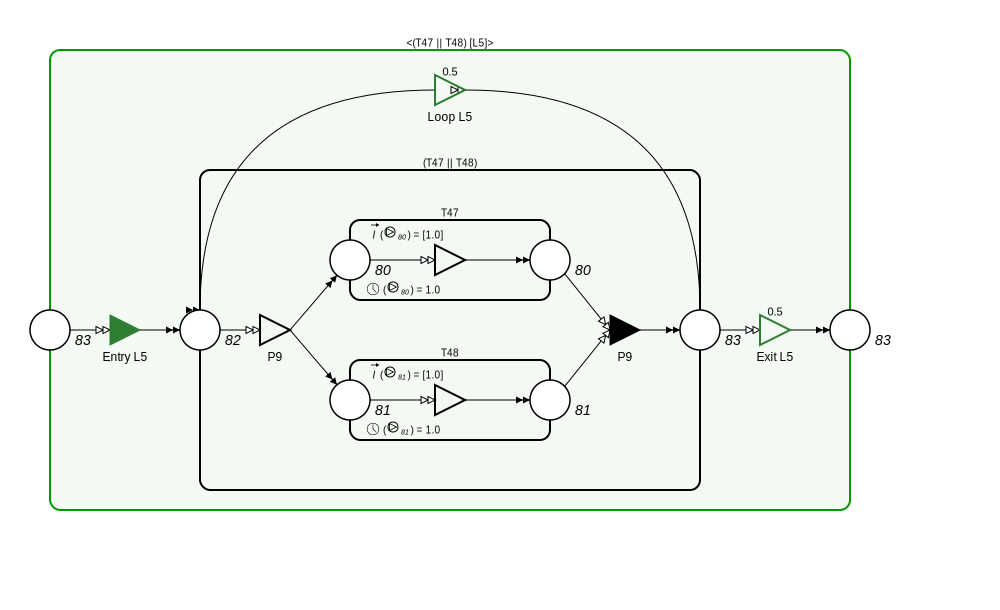

In [37]:
# Expression: <(R1 || R2) [L1]>
region_json = {
    "id": "83",
    "type": "loop",
    "label": "L5",
    "children": [
        {
            "id": "82",
            "type": "parallel",
            "label": "P9",
            "children": [
                {
                    "id": "80",
                    "type": "task",
                    "label": "T47",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "81",
                    "type": "task",
                    "label": "T48",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Loop containing Choice
**Expression**: `<(R1 /[C1] R2) [L1]>`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


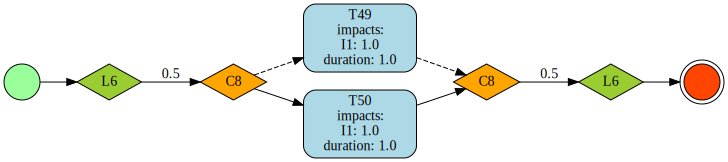


=== Petri Net (PM4PY Standard) ===


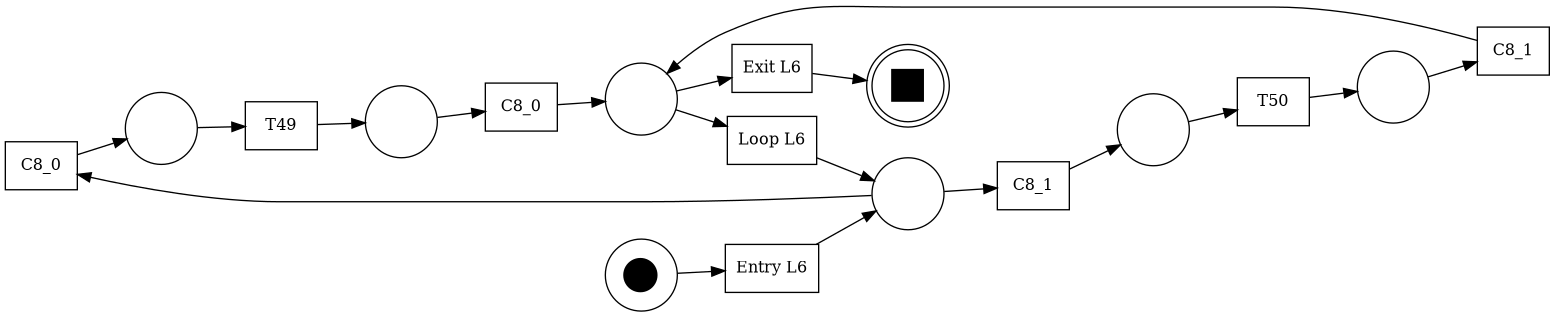


=== SPIN Visualization (Custom SVG) ===


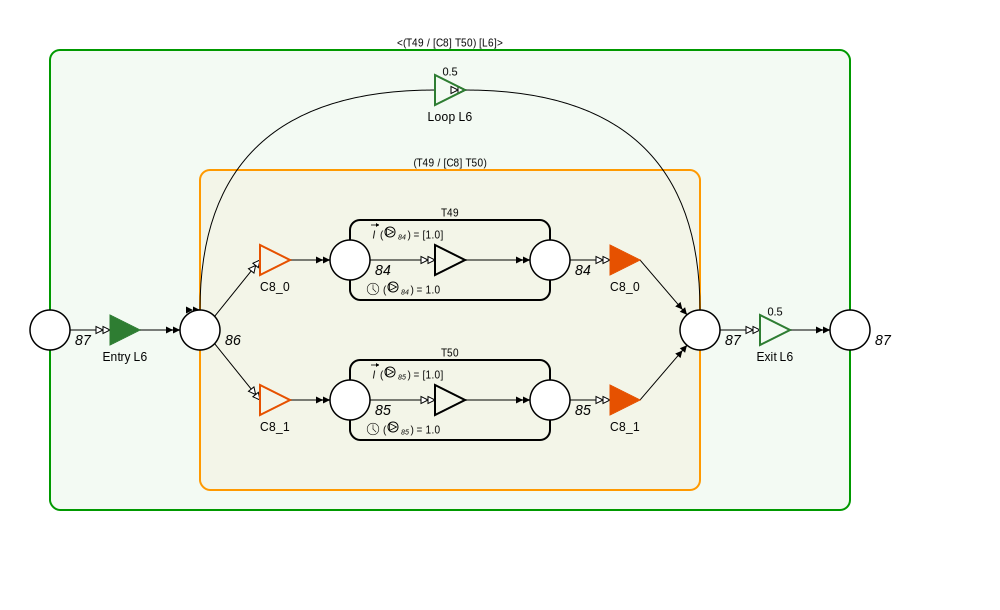

In [38]:
# Expression: <(R1 /[C1] R2) [L1]>
region_json = {
    "id": "87",
    "type": "loop",
    "label": "L6",
    "children": [
        {
            "id": "86",
            "type": "choice",
            "label": "C8",
            "children": [
                {
                    "id": "84",
                    "type": "task",
                    "label": "T49",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "85",
                    "type": "task",
                    "label": "T50",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "max_delay": 0.0
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Loop containing Nature
**Expression**: `<^[N1] (R1, R2) [L1]>`

2026-01-20 13:56:59 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


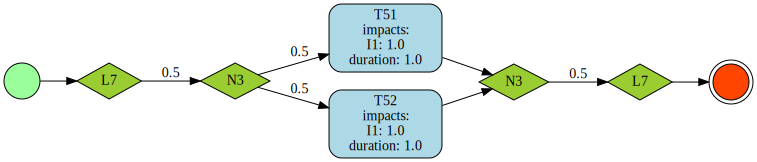


=== Petri Net (PM4PY Standard) ===


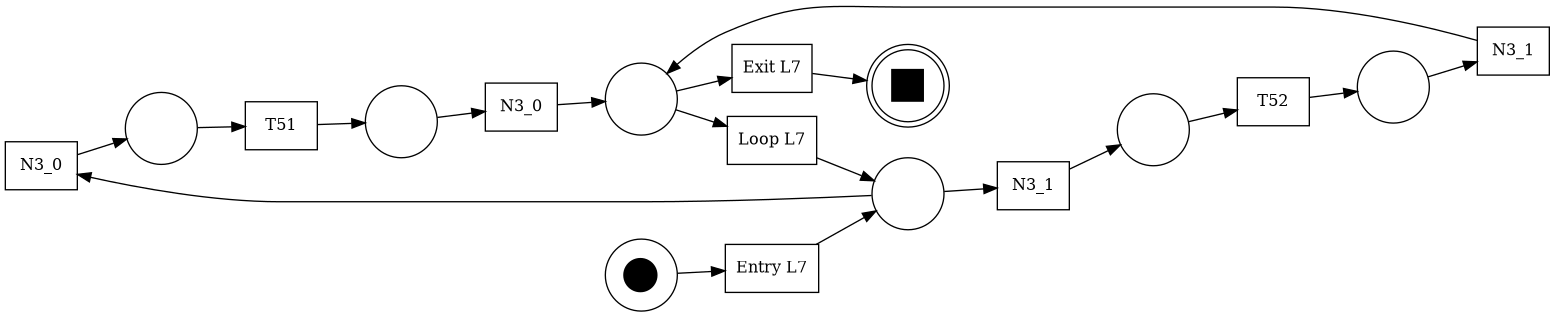


=== SPIN Visualization (Custom SVG) ===


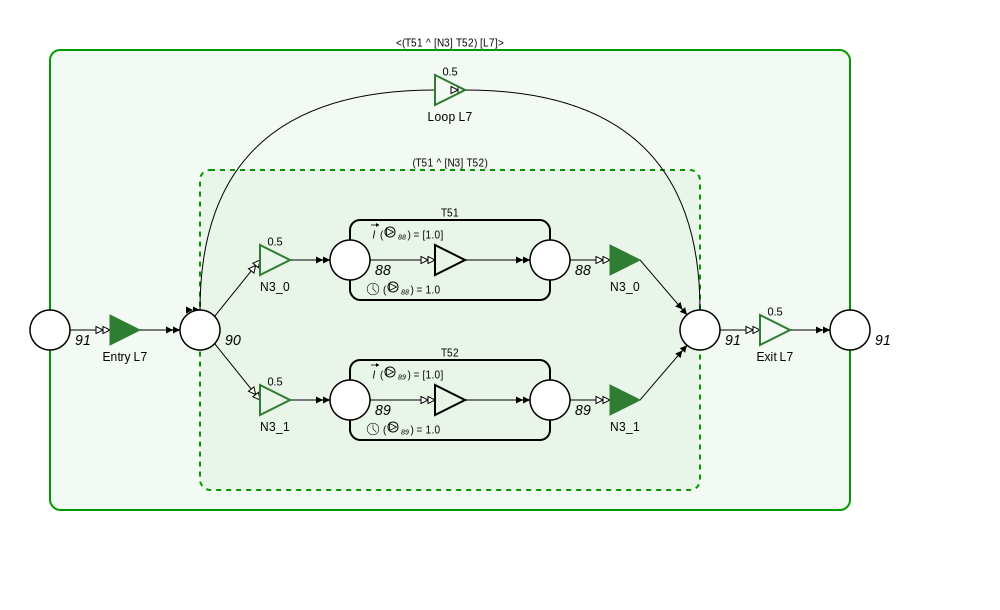

In [39]:
# Expression: <^[N1] (R1, R2) [L1]>
region_json = {
    "id": "91",
    "type": "loop",
    "label": "L7",
    "children": [
        {
            "id": "90",
            "type": "nature",
            "label": "N3",
            "children": [
                {
                    "id": "88",
                    "type": "task",
                    "label": "T51",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "89",
                    "type": "task",
                    "label": "T52",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": [
                0.5,
                0.5
            ]
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nested Loops
**Expression**: `<<R1 [L1]> [L2]>`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


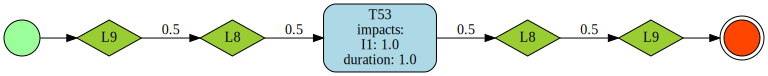


=== Petri Net (PM4PY Standard) ===


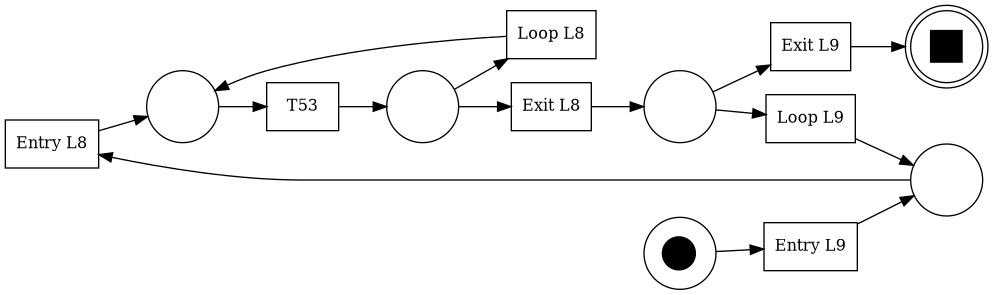


=== SPIN Visualization (Custom SVG) ===


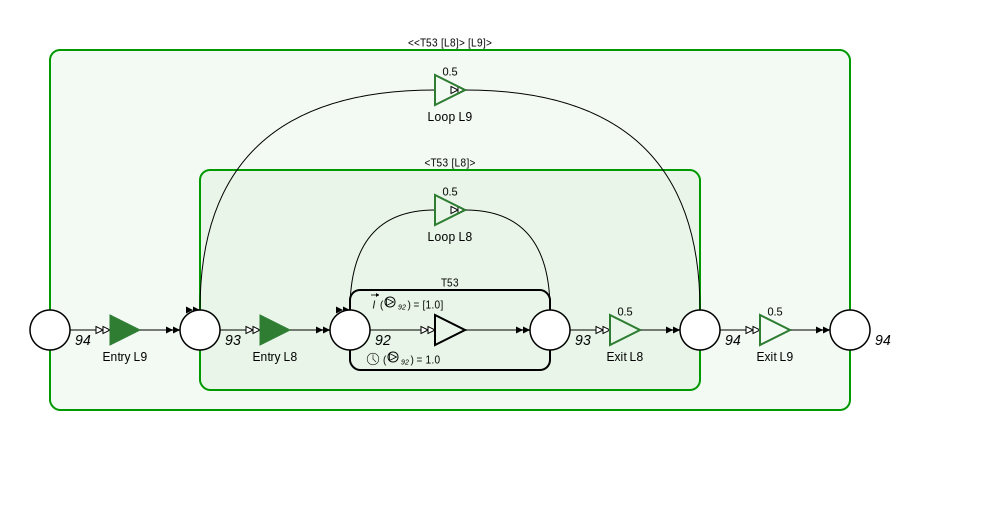

In [40]:
# Expression: <<R1 [L1]> [L2]>
region_json = {
    "id": "94",
    "type": "loop",
    "label": "L9",
    "children": [
        {
            "id": "93",
            "type": "loop",
            "label": "L8",
            "children": [
                {
                    "id": "92",
                    "type": "task",
                    "label": "T53",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": 0.5,
            "bound": 5
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nature containing Parallel
**Expression**: `^[N1] ((R1 || R2), R3)`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


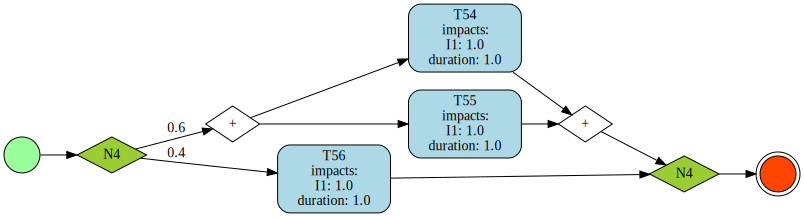


=== Petri Net (PM4PY Standard) ===


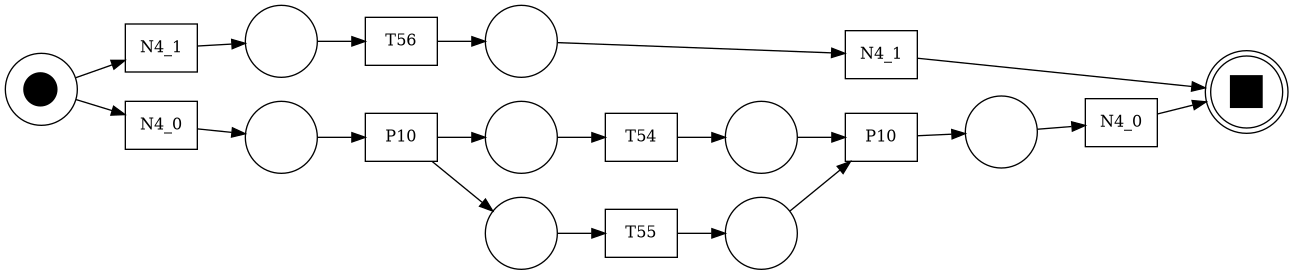


=== SPIN Visualization (Custom SVG) ===


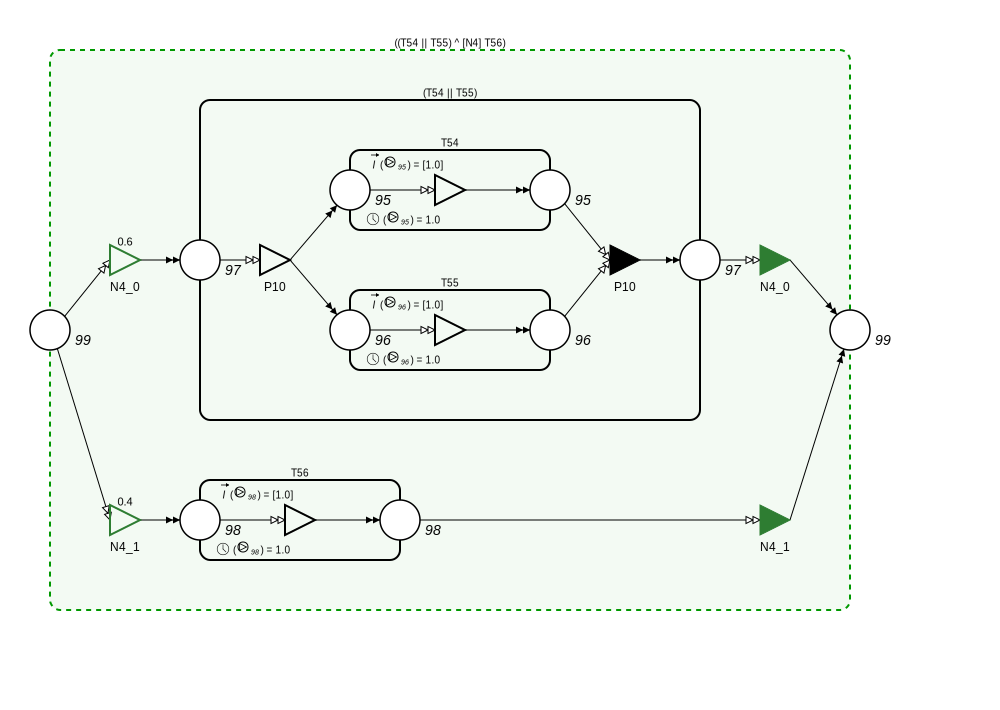

In [41]:
# Expression: ^[N1] ((R1 || R2), R3)
region_json = {
    "id": "99",
    "type": "nature",
    "label": "N4",
    "children": [
        {
            "id": "97",
            "type": "parallel",
            "label": "P10",
            "children": [
                {
                    "id": "95",
                    "type": "task",
                    "label": "T54",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "96",
                    "type": "task",
                    "label": "T55",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "98",
            "type": "task",
            "label": "T56",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.6,
        0.4
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nature containing Choice
**Expression**: `^[N1] ((R1 /[C1] R2), R3)`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


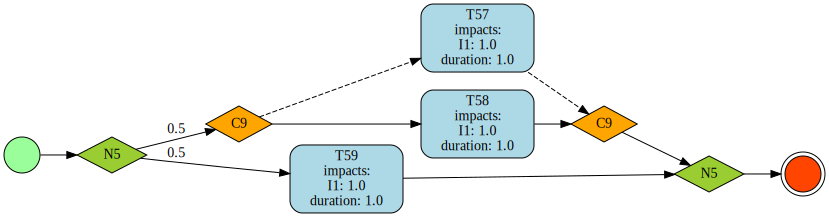


=== Petri Net (PM4PY Standard) ===


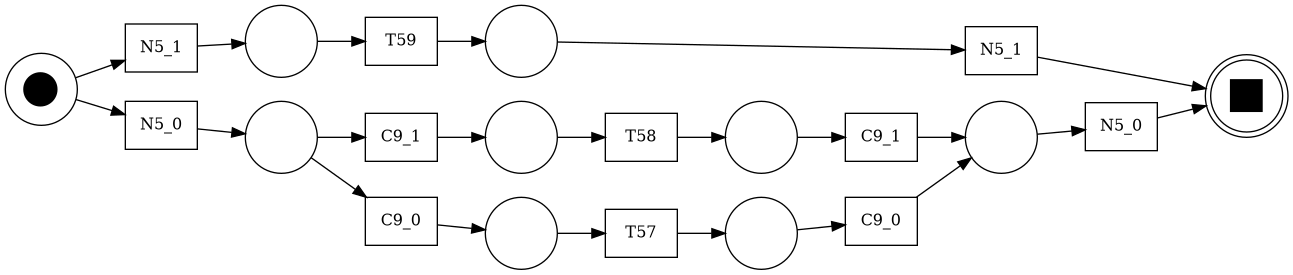


=== SPIN Visualization (Custom SVG) ===


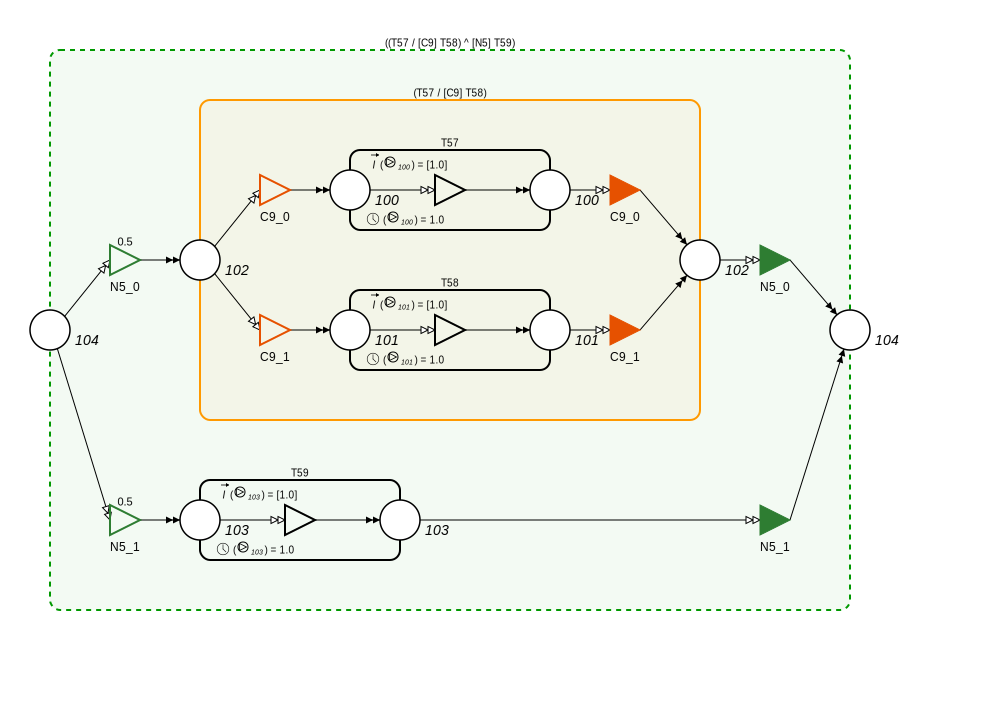

In [42]:
# Expression: ^[N1] ((R1 /[C1] R2), R3)
region_json = {
    "id": "104",
    "type": "nature",
    "label": "N5",
    "children": [
        {
            "id": "102",
            "type": "choice",
            "label": "C9",
            "children": [
                {
                    "id": "100",
                    "type": "task",
                    "label": "T57",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "101",
                    "type": "task",
                    "label": "T58",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "max_delay": 0.0
        },
        {
            "id": "103",
            "type": "task",
            "label": "T59",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.5,
        0.5
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nature containing Loop
**Expression**: `^[N1] (<R1 [L1]>, R2)`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


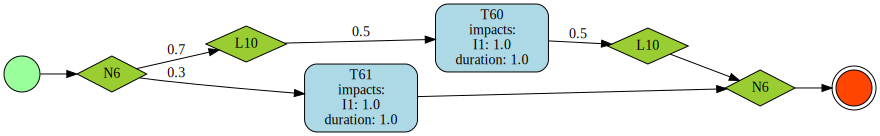


=== Petri Net (PM4PY Standard) ===


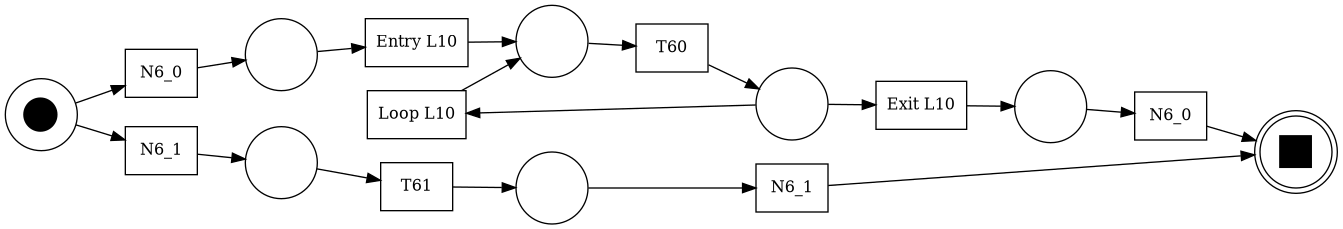


=== SPIN Visualization (Custom SVG) ===


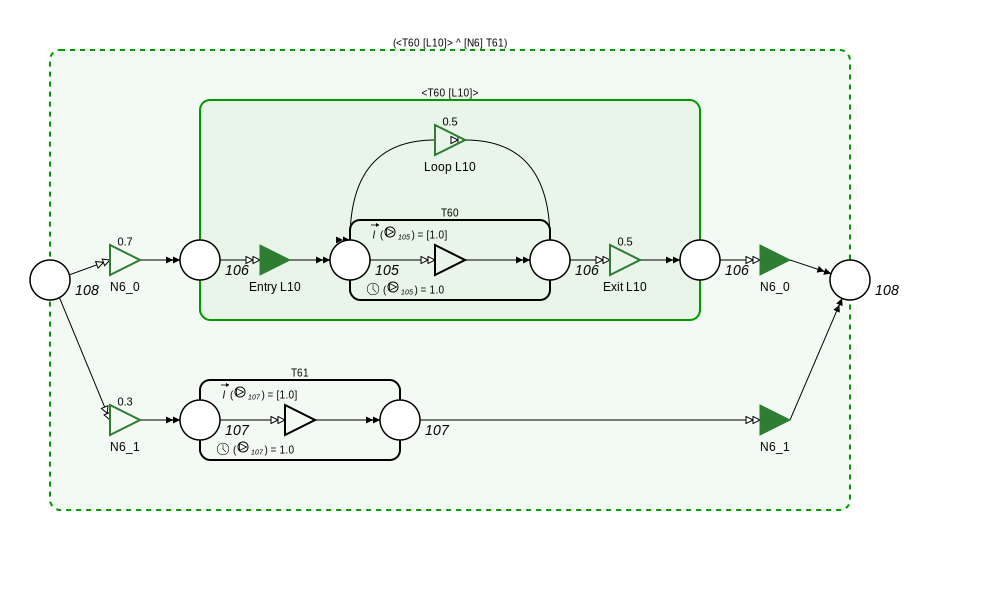

In [43]:
# Expression: ^[N1] (<R1 [L1]>, R2)
region_json = {
    "id": "108",
    "type": "nature",
    "label": "N6",
    "children": [
        {
            "id": "106",
            "type": "loop",
            "label": "L10",
            "children": [
                {
                    "id": "105",
                    "type": "task",
                    "label": "T60",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": 0.5,
            "bound": 5
        },
        {
            "id": "107",
            "type": "task",
            "label": "T61",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.7,
        0.3
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Choice containing Nature
**Expression**: `^[N1](R1, R2) /[C1] R3`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


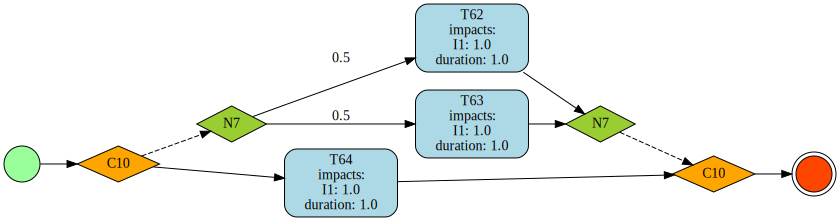


=== Petri Net (PM4PY Standard) ===


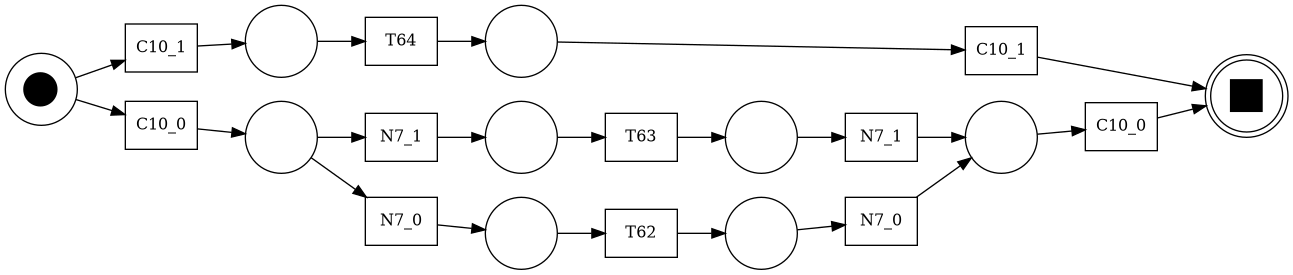


=== SPIN Visualization (Custom SVG) ===


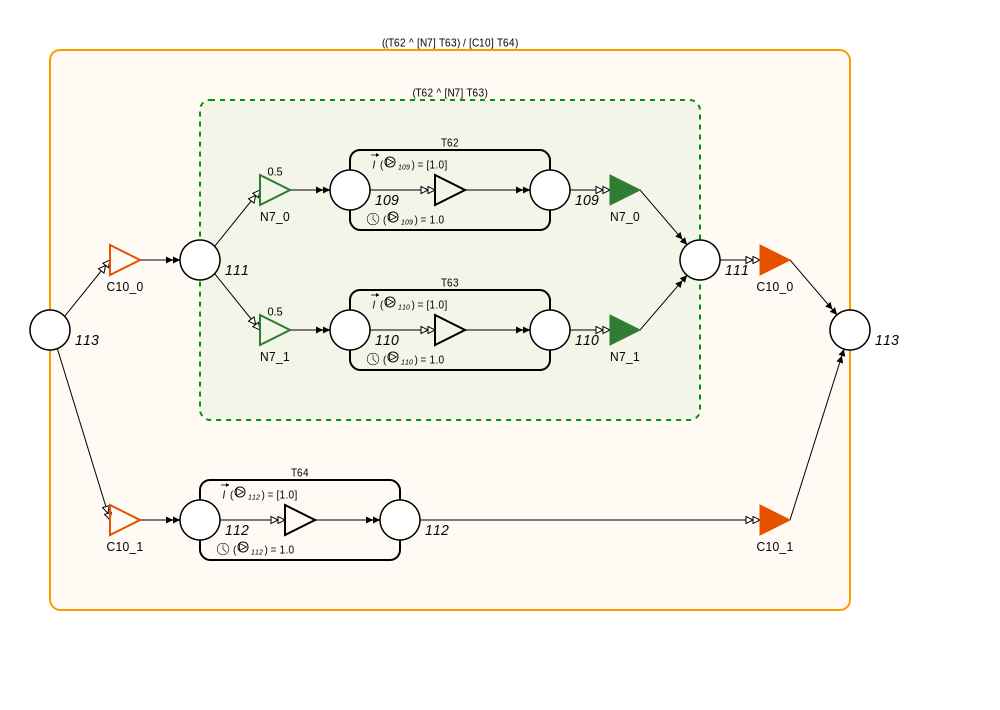

In [44]:
# Expression: ^[N1](R1, R2) /[C1] R3
region_json = {
    "id": "113",
    "type": "choice",
    "label": "C10",
    "children": [
        {
            "id": "111",
            "type": "nature",
            "label": "N7",
            "children": [
                {
                    "id": "109",
                    "type": "task",
                    "label": "T62",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "110",
                    "type": "task",
                    "label": "T63",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": [
                0.5,
                0.5
            ]
        },
        {
            "id": "112",
            "type": "task",
            "label": "T64",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Choice containing Loop
**Expression**: `<R1 [L1]> /[C1] R2`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


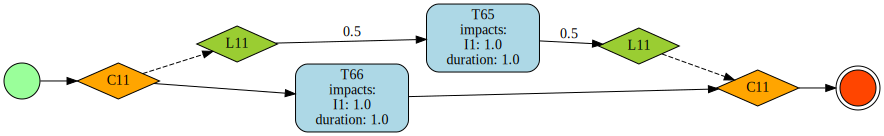


=== Petri Net (PM4PY Standard) ===


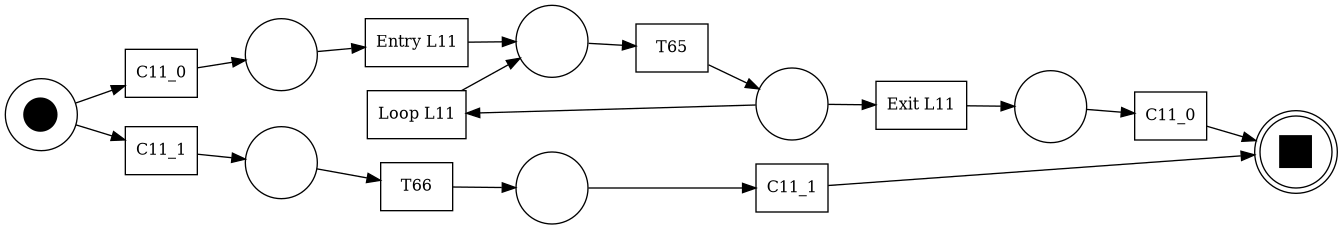


=== SPIN Visualization (Custom SVG) ===


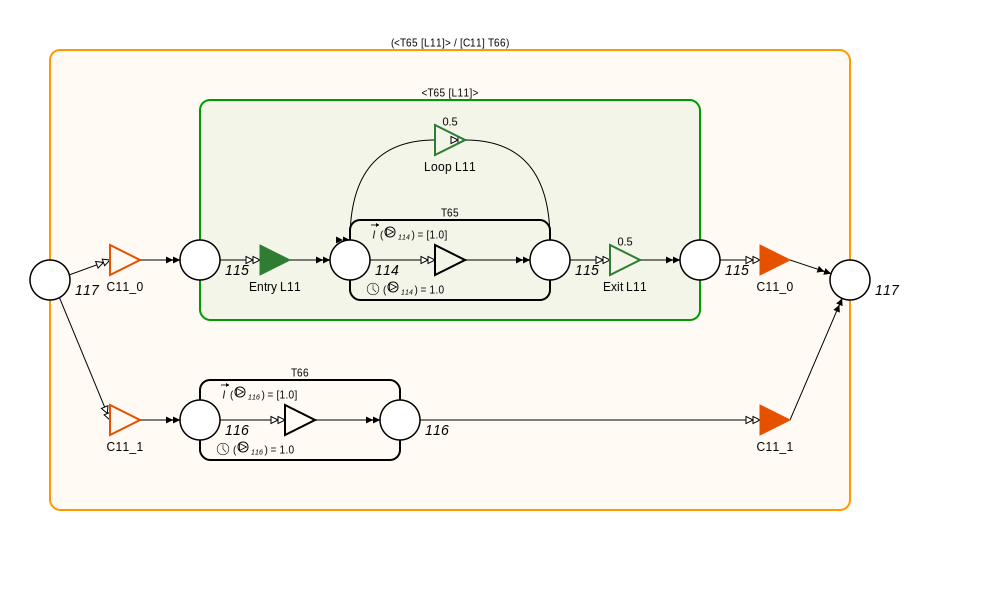

In [45]:
# Expression: <R1 [L1]> /[C1] R2
region_json = {
    "id": "117",
    "type": "choice",
    "label": "C11",
    "children": [
        {
            "id": "115",
            "type": "loop",
            "label": "L11",
            "children": [
                {
                    "id": "114",
                    "type": "task",
                    "label": "T65",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": 0.5,
            "bound": 5
        },
        {
            "id": "116",
            "type": "task",
            "label": "T66",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel Three Branches
**Expression**: `R1 || R2 || R3`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


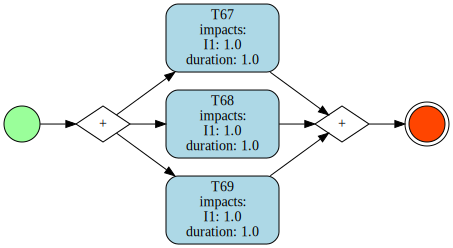


=== Petri Net (PM4PY Standard) ===


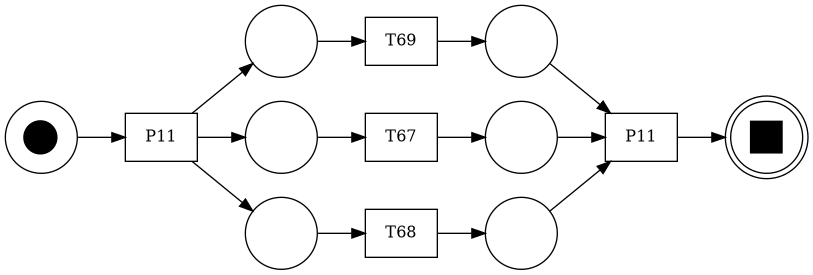


=== SPIN Visualization (Custom SVG) ===


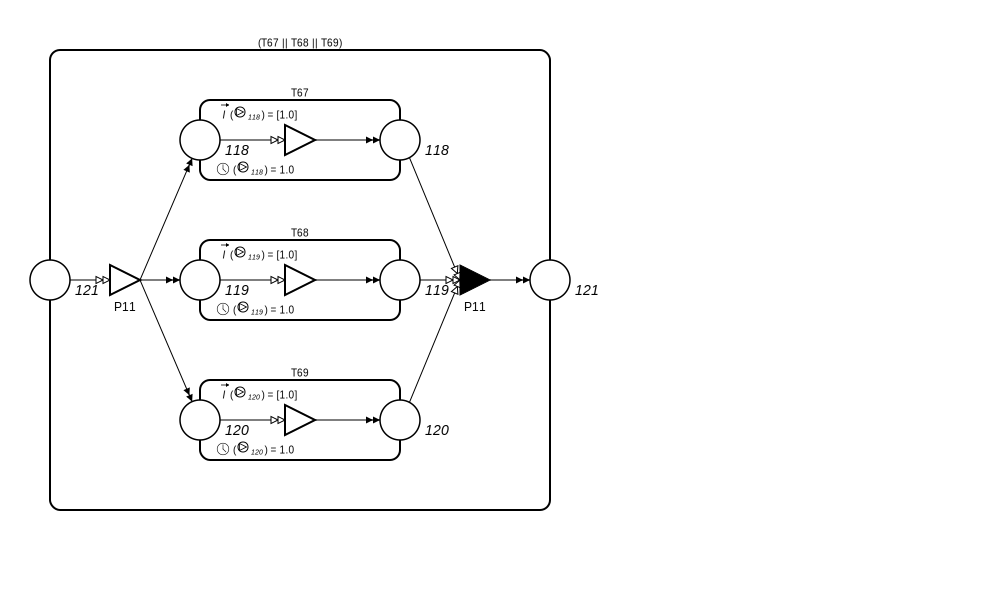

In [46]:
# Expression: R1 || R2 || R3
region_json = {
    "id": "121",
    "type": "parallel",
    "label": "P11",
    "children": [
        {
            "id": "118",
            "type": "task",
            "label": "T67",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "119",
            "type": "task",
            "label": "T68",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "120",
            "type": "task",
            "label": "T69",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel in Loop in Sequence
**Expression**: `R1, <(R2 || R3) [L1]>, R4`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


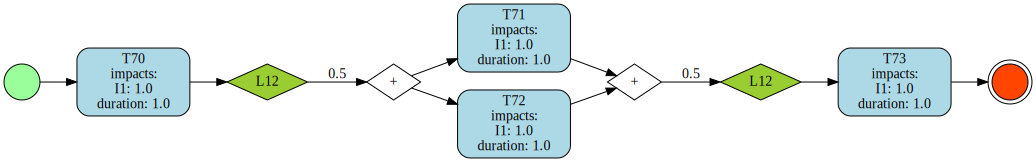


=== Petri Net (PM4PY Standard) ===


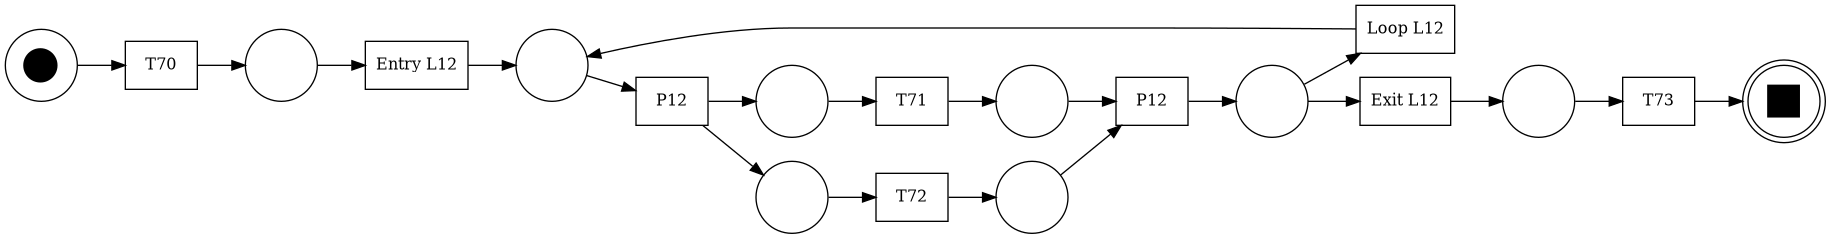


=== SPIN Visualization (Custom SVG) ===


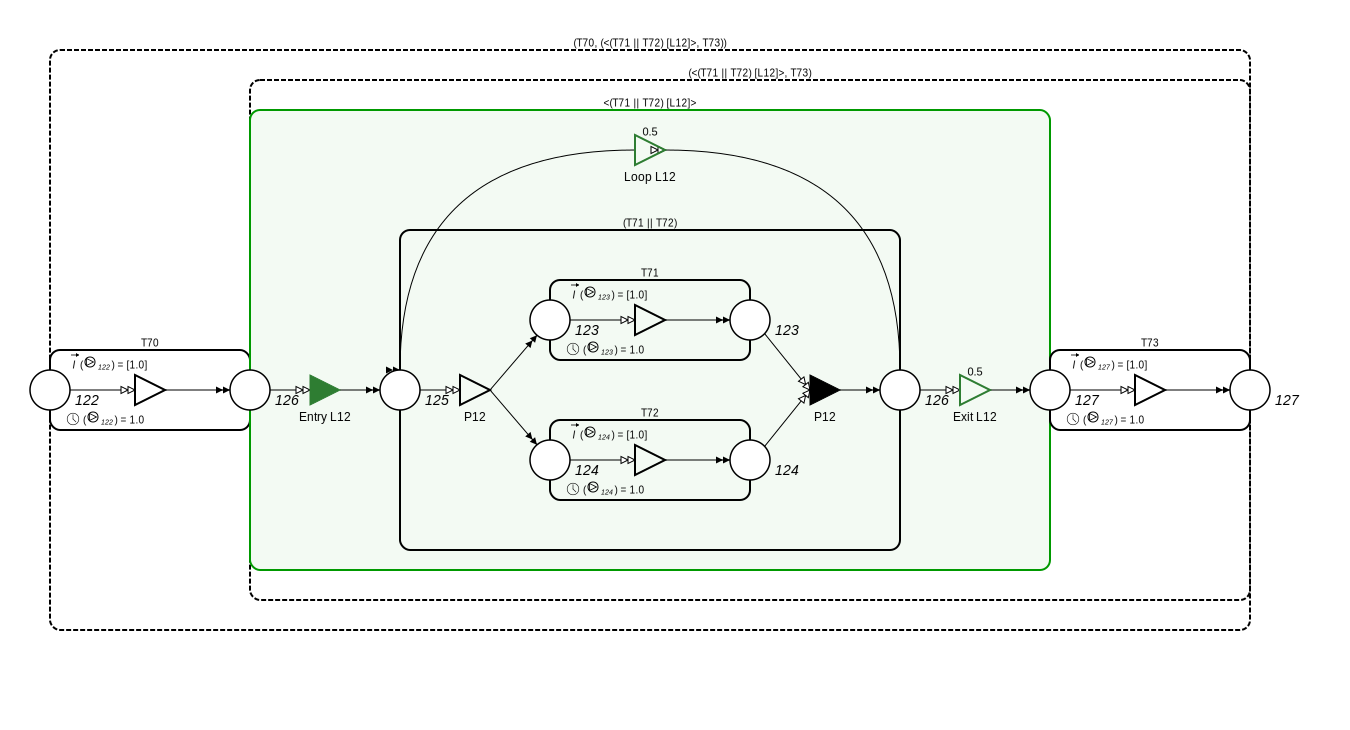

In [47]:
# Expression: R1, <(R2 || R3) [L1]>, R4
region_json = {
    "id": "129",
    "type": "sequential",
    "children": [
        {
            "id": "122",
            "type": "task",
            "label": "T70",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "128",
            "type": "sequential",
            "children": [
                {
                    "id": "126",
                    "type": "loop",
                    "label": "L12",
                    "children": [
                        {
                            "id": "125",
                            "type": "parallel",
                            "label": "P12",
                            "children": [
                                {
                                    "id": "123",
                                    "type": "task",
                                    "label": "T71",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                },
                                {
                                    "id": "124",
                                    "type": "task",
                                    "label": "T72",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                }
                            ]
                        }
                    ],
                    "distribution": 0.5,
                    "bound": 5
                },
                {
                    "id": "127",
                    "type": "task",
                    "label": "T73",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Parallel containing Nature
**Expression**: `R1 || ^[N1](R2, R3)`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


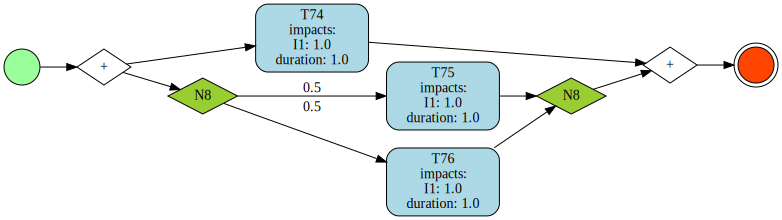


=== Petri Net (PM4PY Standard) ===


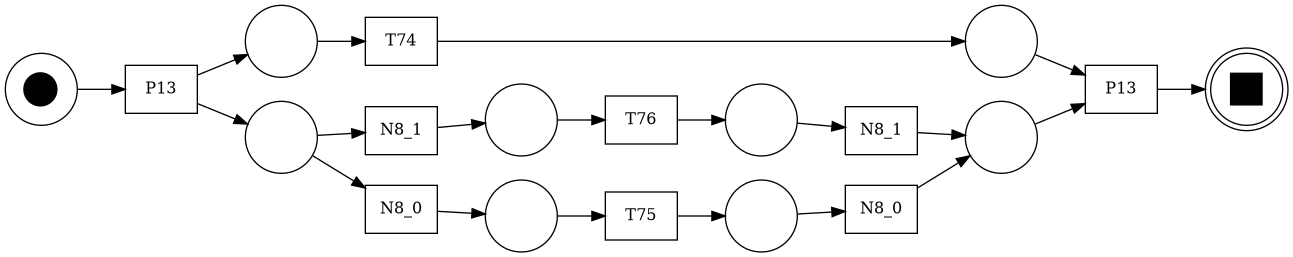


=== SPIN Visualization (Custom SVG) ===


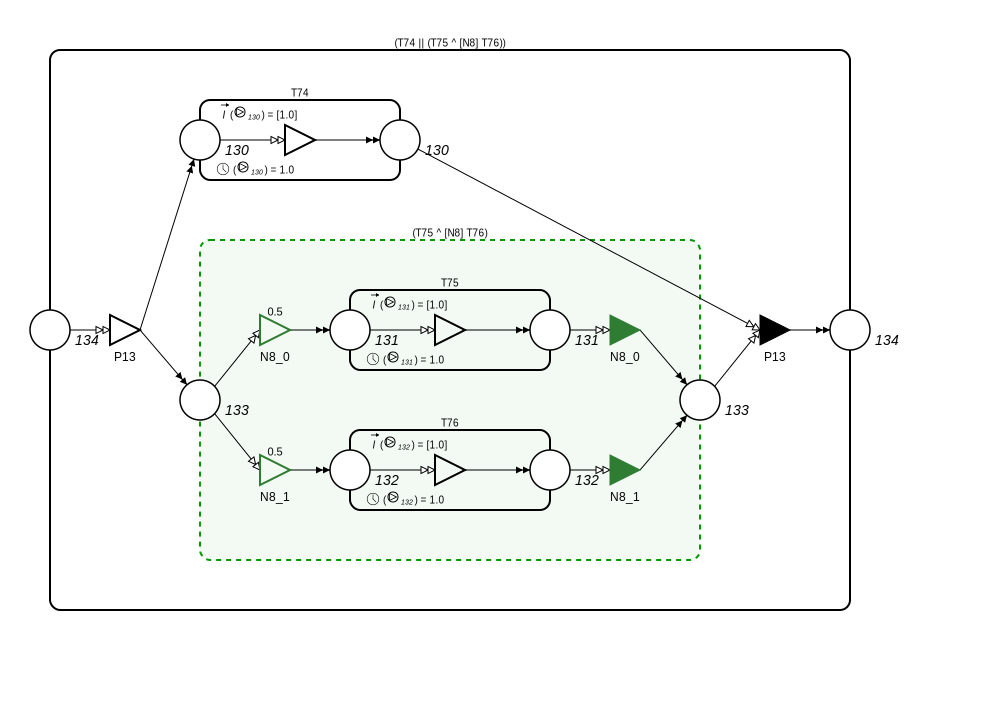

In [48]:
# Expression: R1 || ^[N1](R2, R3)
region_json = {
    "id": "134",
    "type": "parallel",
    "label": "P13",
    "children": [
        {
            "id": "130",
            "type": "task",
            "label": "T74",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "133",
            "type": "nature",
            "label": "N8",
            "children": [
                {
                    "id": "131",
                    "type": "task",
                    "label": "T75",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "132",
                    "type": "task",
                    "label": "T76",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": [
                0.5,
                0.5
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nested Parallel
**Expression**: `(R1 || R2) || R3`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


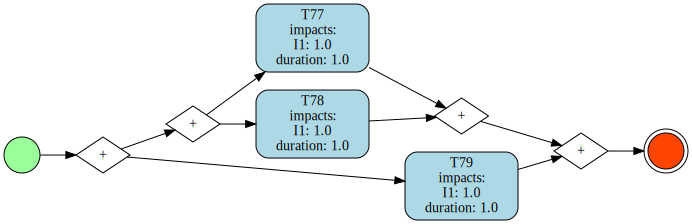


=== Petri Net (PM4PY Standard) ===


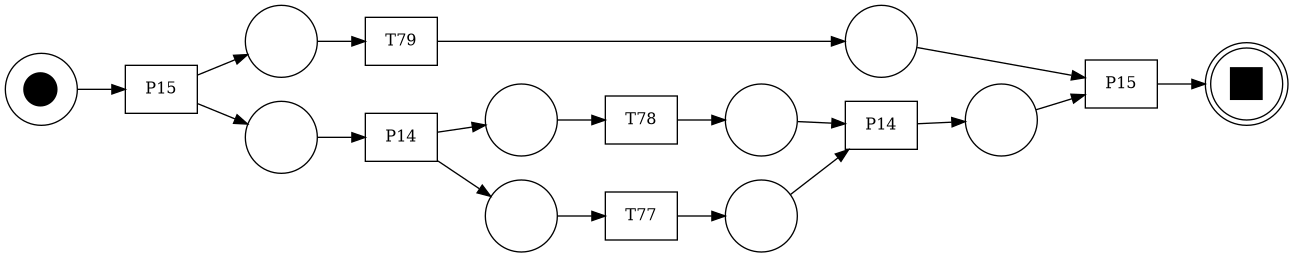


=== SPIN Visualization (Custom SVG) ===


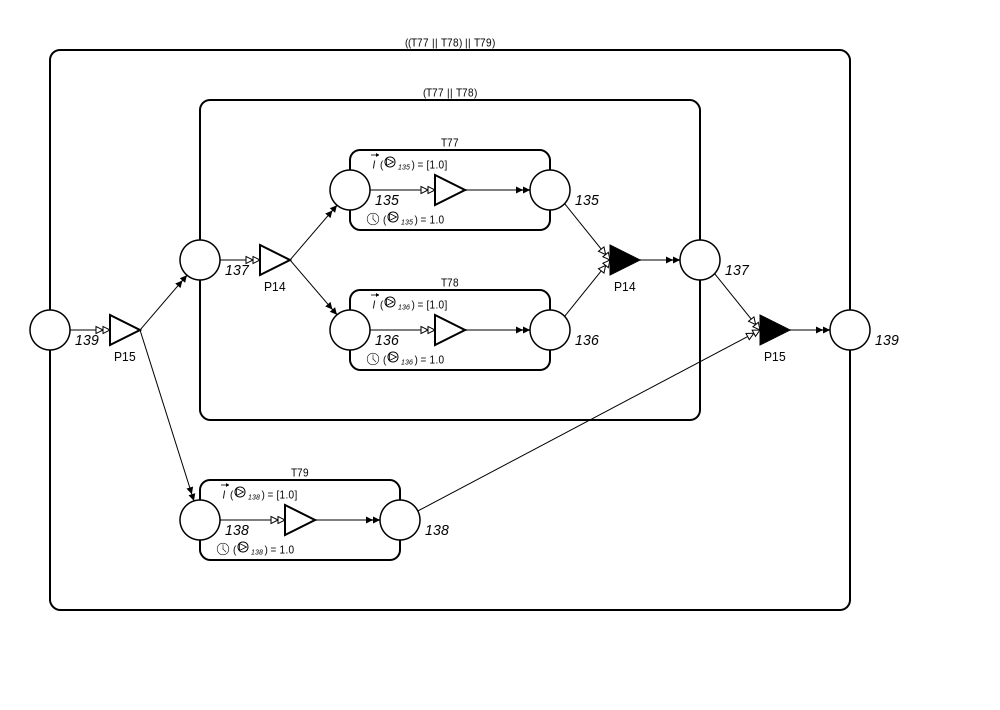

In [49]:
# Expression: (R1 || R2) || R3
region_json = {
    "id": "139",
    "type": "parallel",
    "label": "P15",
    "children": [
        {
            "id": "137",
            "type": "parallel",
            "label": "P14",
            "children": [
                {
                    "id": "135",
                    "type": "task",
                    "label": "T77",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "136",
                    "type": "task",
                    "label": "T78",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "138",
            "type": "task",
            "label": "T79",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Choice containing Sequential
**Expression**: `(R1, R2) /[C1] R3`

2026-01-20 13:57:00 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


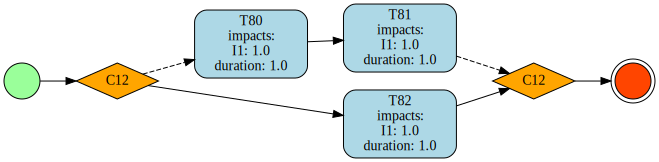


=== Petri Net (PM4PY Standard) ===


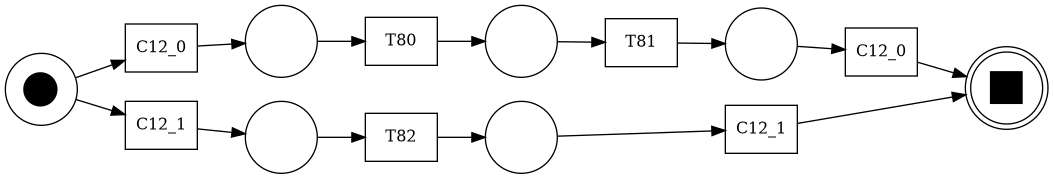


=== SPIN Visualization (Custom SVG) ===


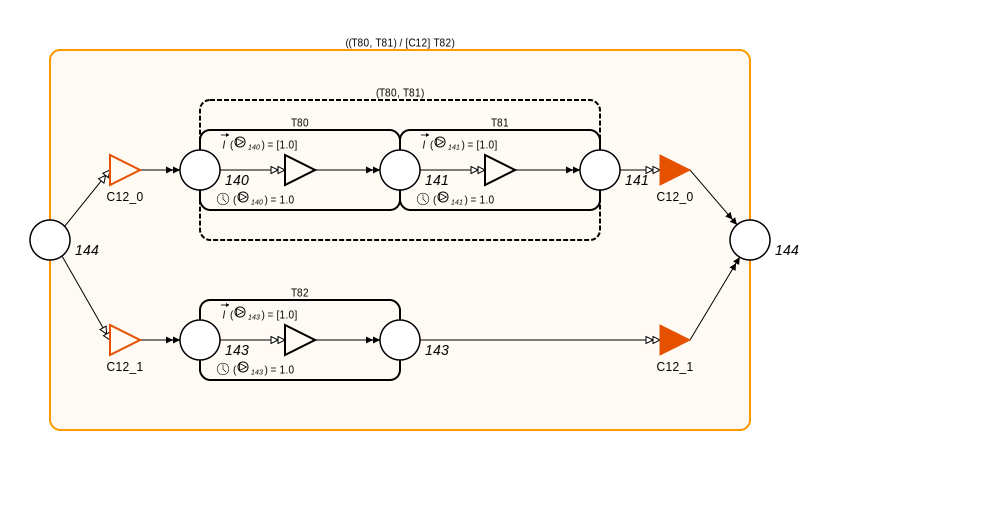

In [50]:
# Expression: (R1, R2) /[C1] R3
region_json = {
    "id": "144",
    "type": "choice",
    "label": "C12",
    "children": [
        {
            "id": "142",
            "type": "sequential",
            "children": [
                {
                    "id": "140",
                    "type": "task",
                    "label": "T80",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "141",
                    "type": "task",
                    "label": "T81",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "143",
            "type": "task",
            "label": "T82",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "max_delay": 0.0
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nature containing Sequential
**Expression**: `^[N1]((R1, R2), R3)`

2026-01-20 13:57:01 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


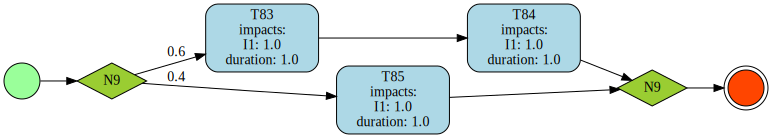


=== Petri Net (PM4PY Standard) ===


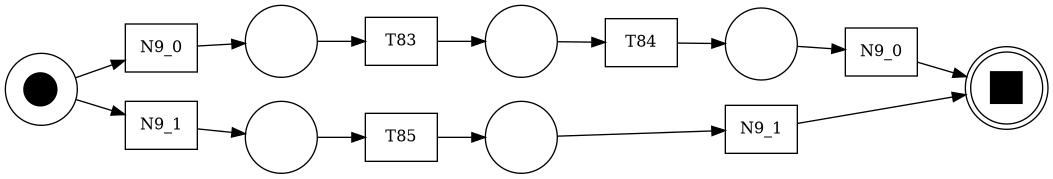


=== SPIN Visualization (Custom SVG) ===


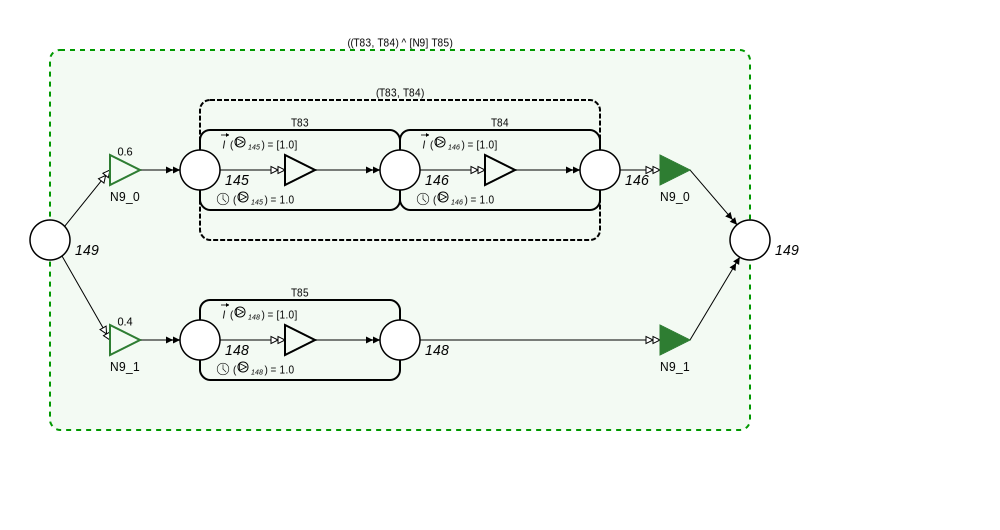

In [51]:
# Expression: ^[N1]((R1, R2), R3)
region_json = {
    "id": "149",
    "type": "nature",
    "label": "N9",
    "children": [
        {
            "id": "147",
            "type": "sequential",
            "children": [
                {
                    "id": "145",
                    "type": "task",
                    "label": "T83",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "146",
                    "type": "task",
                    "label": "T84",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "148",
            "type": "task",
            "label": "T85",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.6,
        0.4
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Loop containing Sequential
**Expression**: `<(R1, R2) [L1]>`

2026-01-20 13:57:01 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


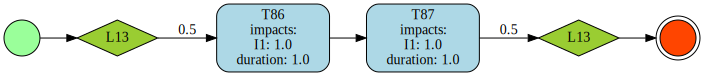


=== Petri Net (PM4PY Standard) ===


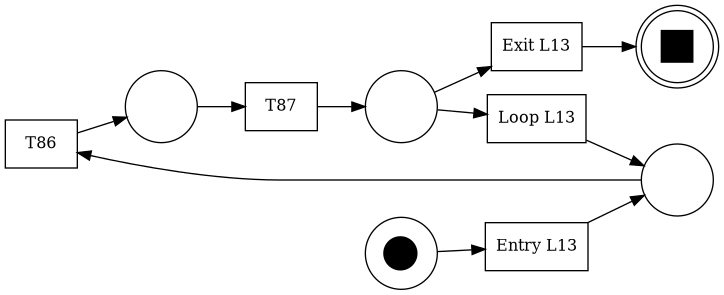


=== SPIN Visualization (Custom SVG) ===


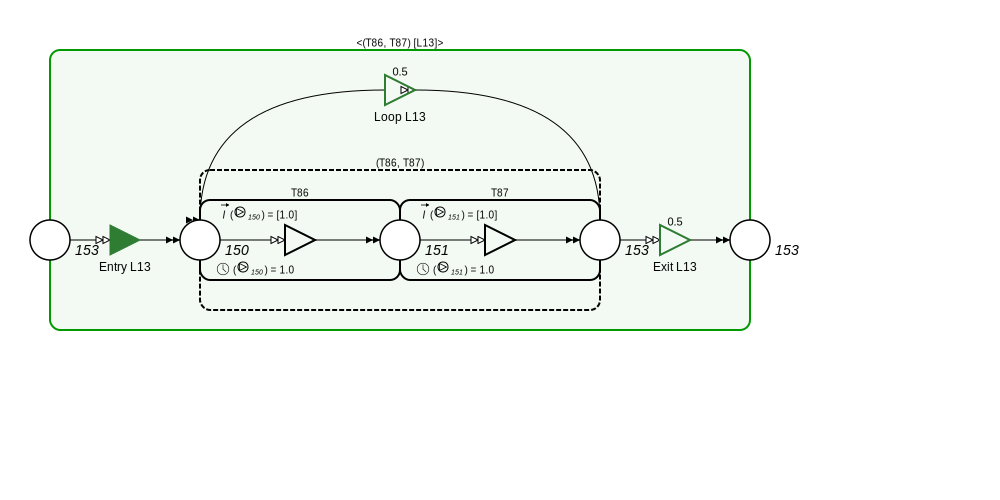

In [52]:
# Expression: <(R1, R2) [L1]>
region_json = {
    "id": "153",
    "type": "loop",
    "label": "L13",
    "children": [
        {
            "id": "152",
            "type": "sequential",
            "children": [
                {
                    "id": "150",
                    "type": "task",
                    "label": "T86",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "151",
                    "type": "task",
                    "label": "T87",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Nested Nature
**Expression**: `^[N1](^[N2](R1, R2), R3)`

2026-01-20 13:57:01 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


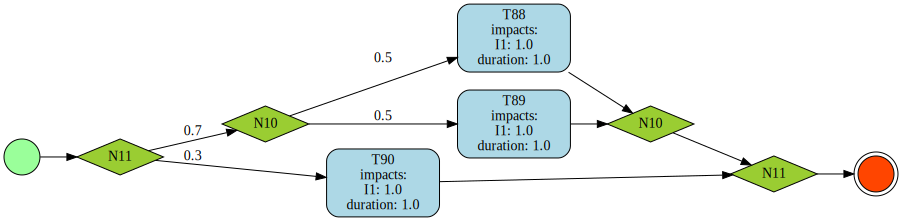


=== Petri Net (PM4PY Standard) ===


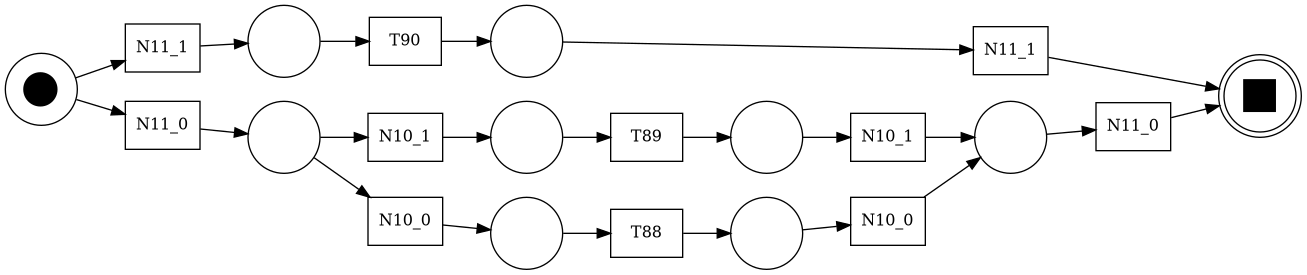


=== SPIN Visualization (Custom SVG) ===


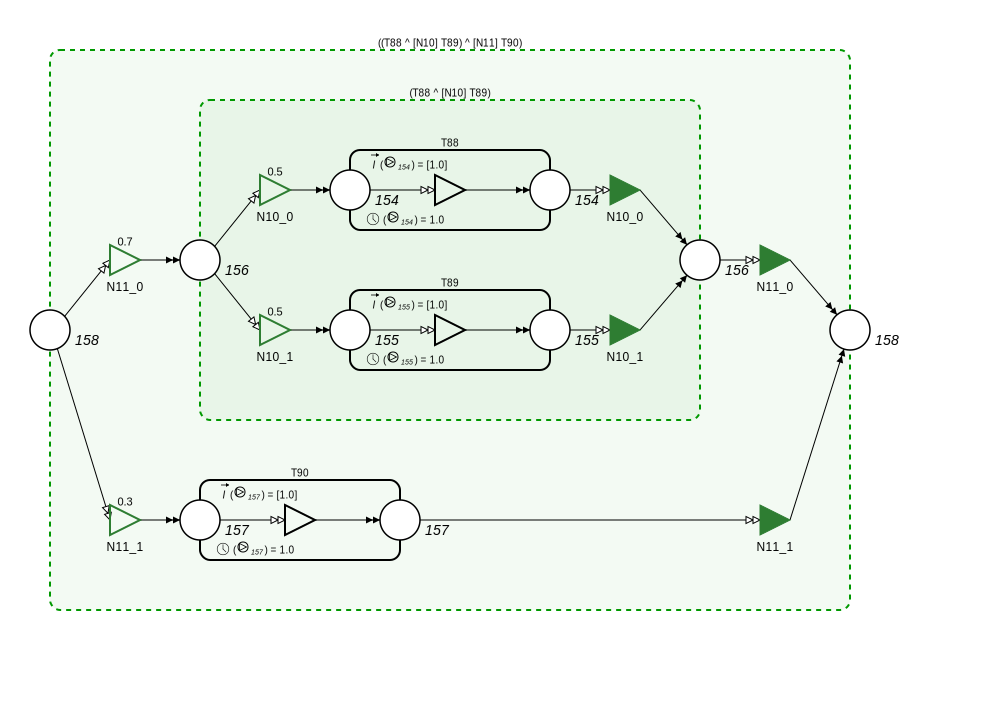

In [53]:
# Expression: ^[N1](^[N2](R1, R2), R3)
region_json = {
    "id": "158",
    "type": "nature",
    "label": "N11",
    "children": [
        {
            "id": "156",
            "type": "nature",
            "label": "N10",
            "children": [
                {
                    "id": "154",
                    "type": "task",
                    "label": "T88",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "155",
                    "type": "task",
                    "label": "T89",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": [
                0.5,
                0.5
            ]
        },
        {
            "id": "157",
            "type": "task",
            "label": "T90",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ],
    "distribution": [
        0.7,
        0.3
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Massive Parallel
**Expression**: `Massive Parallel (8 branches)`

2026-01-20 13:57:01 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


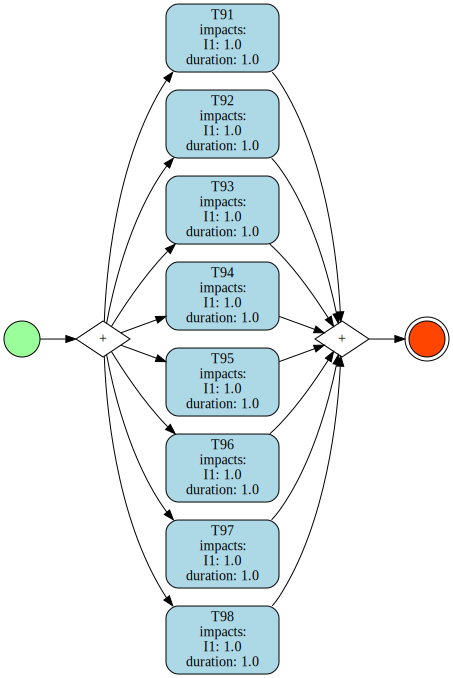


=== Petri Net (PM4PY Standard) ===


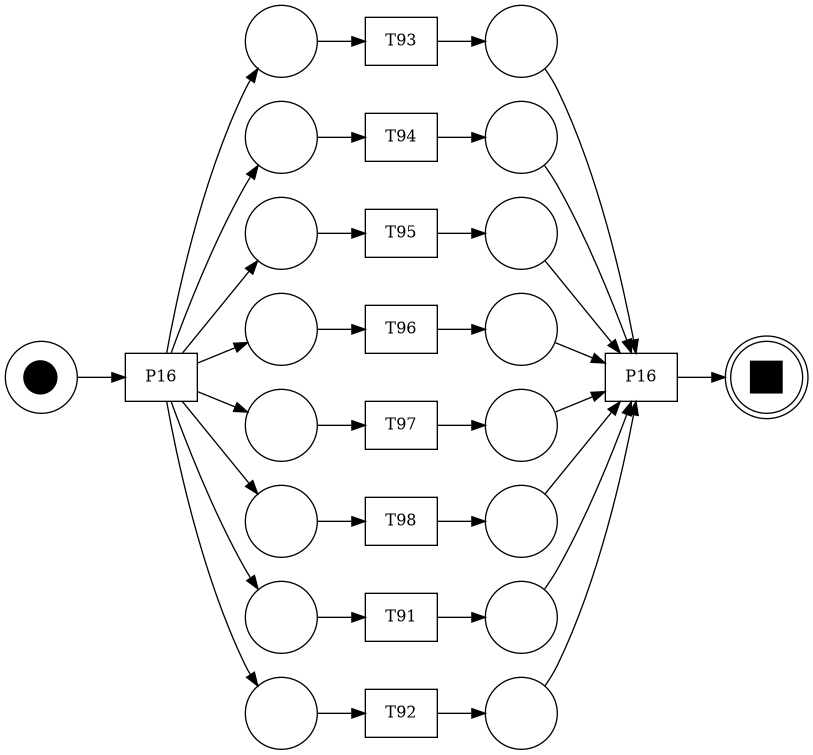


=== SPIN Visualization (Custom SVG) ===


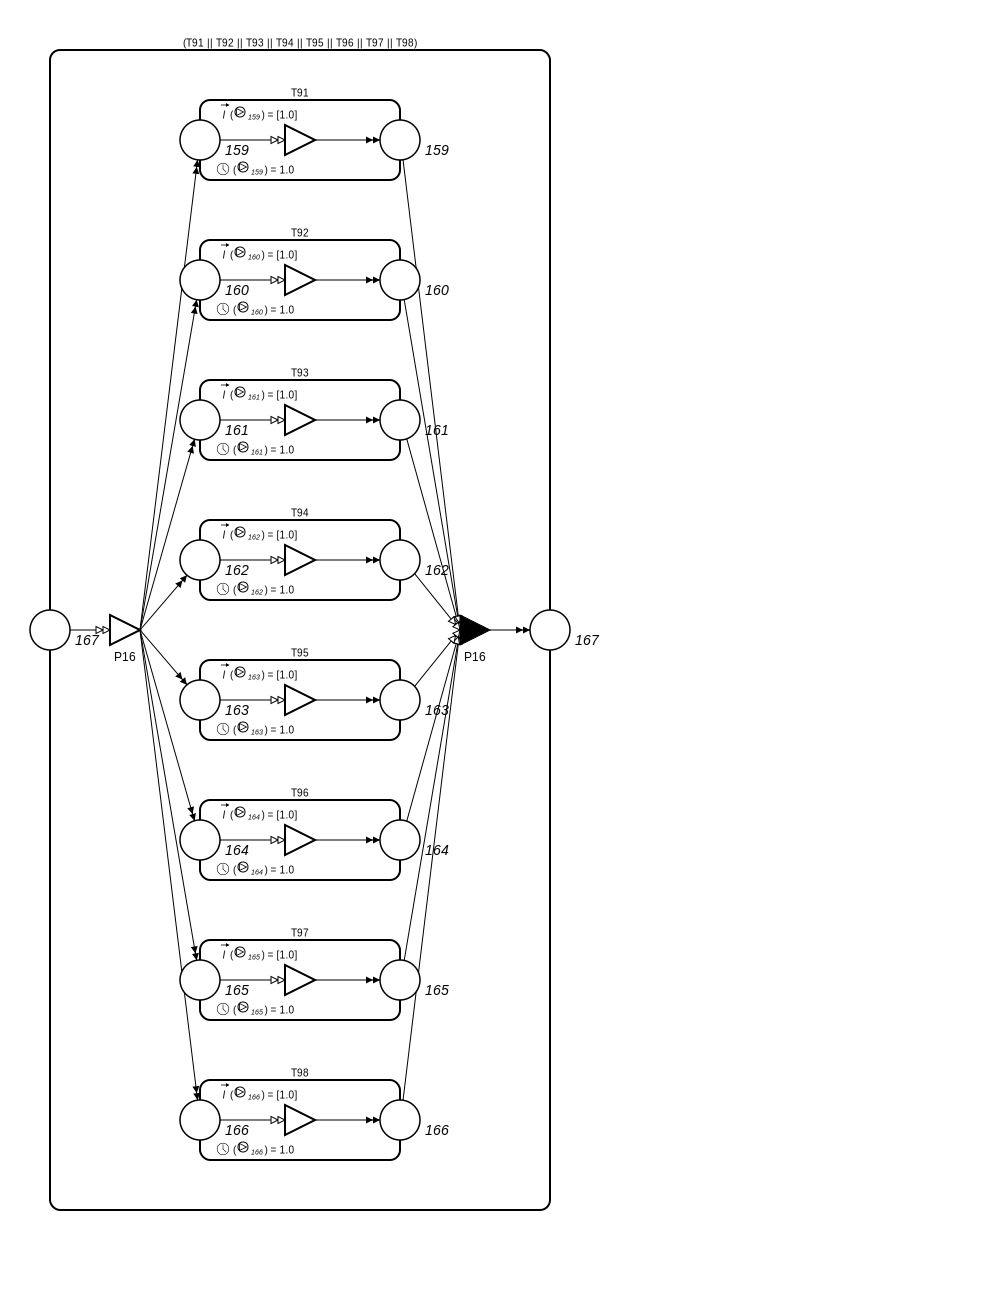

In [54]:
# Expression: Massive Parallel (8 branches)
region_json = {
    "id": "167",
    "type": "parallel",
    "label": "P16",
    "children": [
        {
            "id": "159",
            "type": "task",
            "label": "T91",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "160",
            "type": "task",
            "label": "T92",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "161",
            "type": "task",
            "label": "T93",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "162",
            "type": "task",
            "label": "T94",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "163",
            "type": "task",
            "label": "T95",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "164",
            "type": "task",
            "label": "T96",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "165",
            "type": "task",
            "label": "T97",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "166",
            "type": "task",
            "label": "T98",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Deep Sequence
**Expression**: `T1 -> T2 -> ... -> T10`

In [55]:
# Expression: T1 -> T2 -> ... -> T10
region_json = {
    "id": "178",
    "type": "sequential",
    "children": [
        {
            "id": "168",
            "type": "task",
            "label": "T99",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "169",
            "type": "task",
            "label": "T100",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "170",
            "type": "task",
            "label": "T101",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "171",
            "type": "task",
            "label": "T102",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "172",
            "type": "task",
            "label": "T103",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "173",
            "type": "task",
            "label": "T104",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "174",
            "type": "task",
            "label": "T105",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "175",
            "type": "task",
            "label": "T106",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "176",
            "type": "task",
            "label": "T107",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        },
        {
            "id": "177",
            "type": "task",
            "label": "T108",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


2026-01-20 13:57:01 - ERROR - Sequential region None id:178 has more than 2 children: 10
2026-01-20 13:57:01 - ERROR - Invalid data, can't convert to Petri net


ValidationError: The region is not valid, therefore it cannot be correctly translated into a Petri Net

## Wide Parallel
**Expression**: `(T1->...->T5) || T6`

In [56]:
# Expression: (T1->...->T5) || T6
region_json = {
    "id": "186",
    "type": "parallel",
    "label": "P17",
    "children": [
        {
            "id": "184",
            "type": "sequential",
            "children": [
                {
                    "id": "179",
                    "type": "task",
                    "label": "T109",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "180",
                    "type": "task",
                    "label": "T110",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "181",
                    "type": "task",
                    "label": "T111",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "182",
                    "type": "task",
                    "label": "T112",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                },
                {
                    "id": "183",
                    "type": "task",
                    "label": "T113",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ]
        },
        {
            "id": "185",
            "type": "task",
            "label": "T114",
            "duration": 1.0,
            "impacts": [
                1.0
            ]
        }
    ]
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


2026-01-20 13:57:38 - ERROR - Sequential region None id:184 has more than 2 children: 5
2026-01-20 13:57:38 - ERROR - Invalid data, can't convert to Petri net


ValidationError: The region is not valid, therefore it cannot be correctly translated into a Petri Net

## Kitchen Sink
**Expression**: `< ^[N]( [C]( (T||T), T ), T ) [L] >`

2026-01-20 13:57:56 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


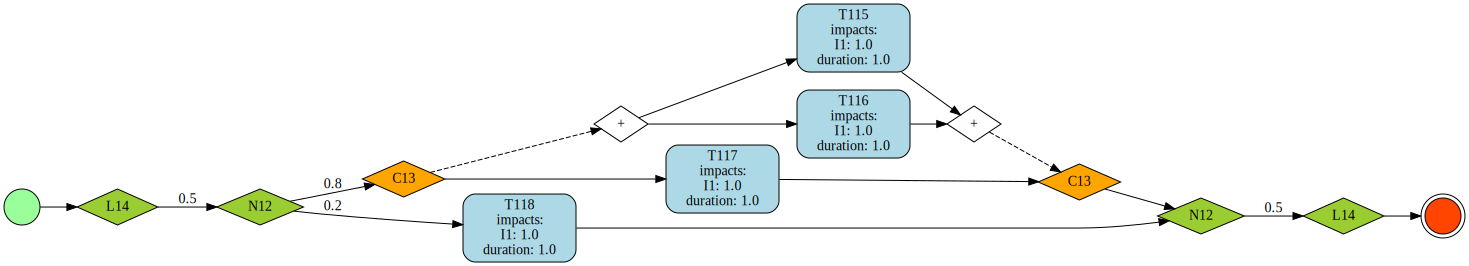


=== Petri Net (PM4PY Standard) ===


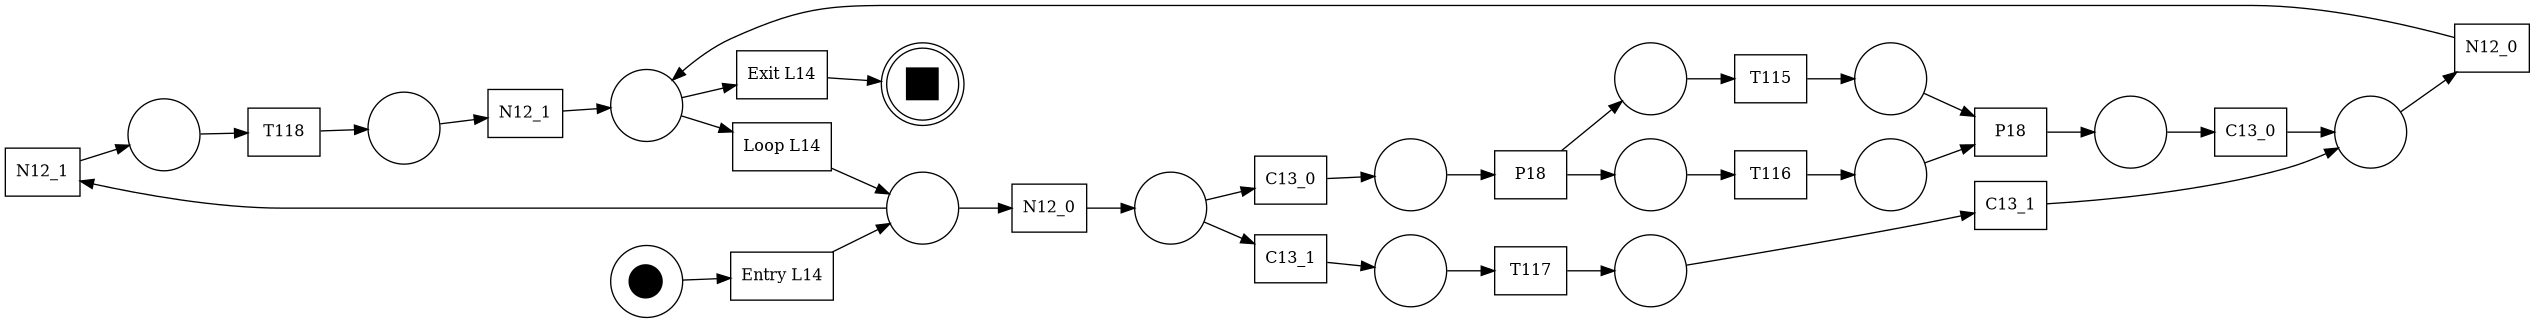


=== SPIN Visualization (Custom SVG) ===


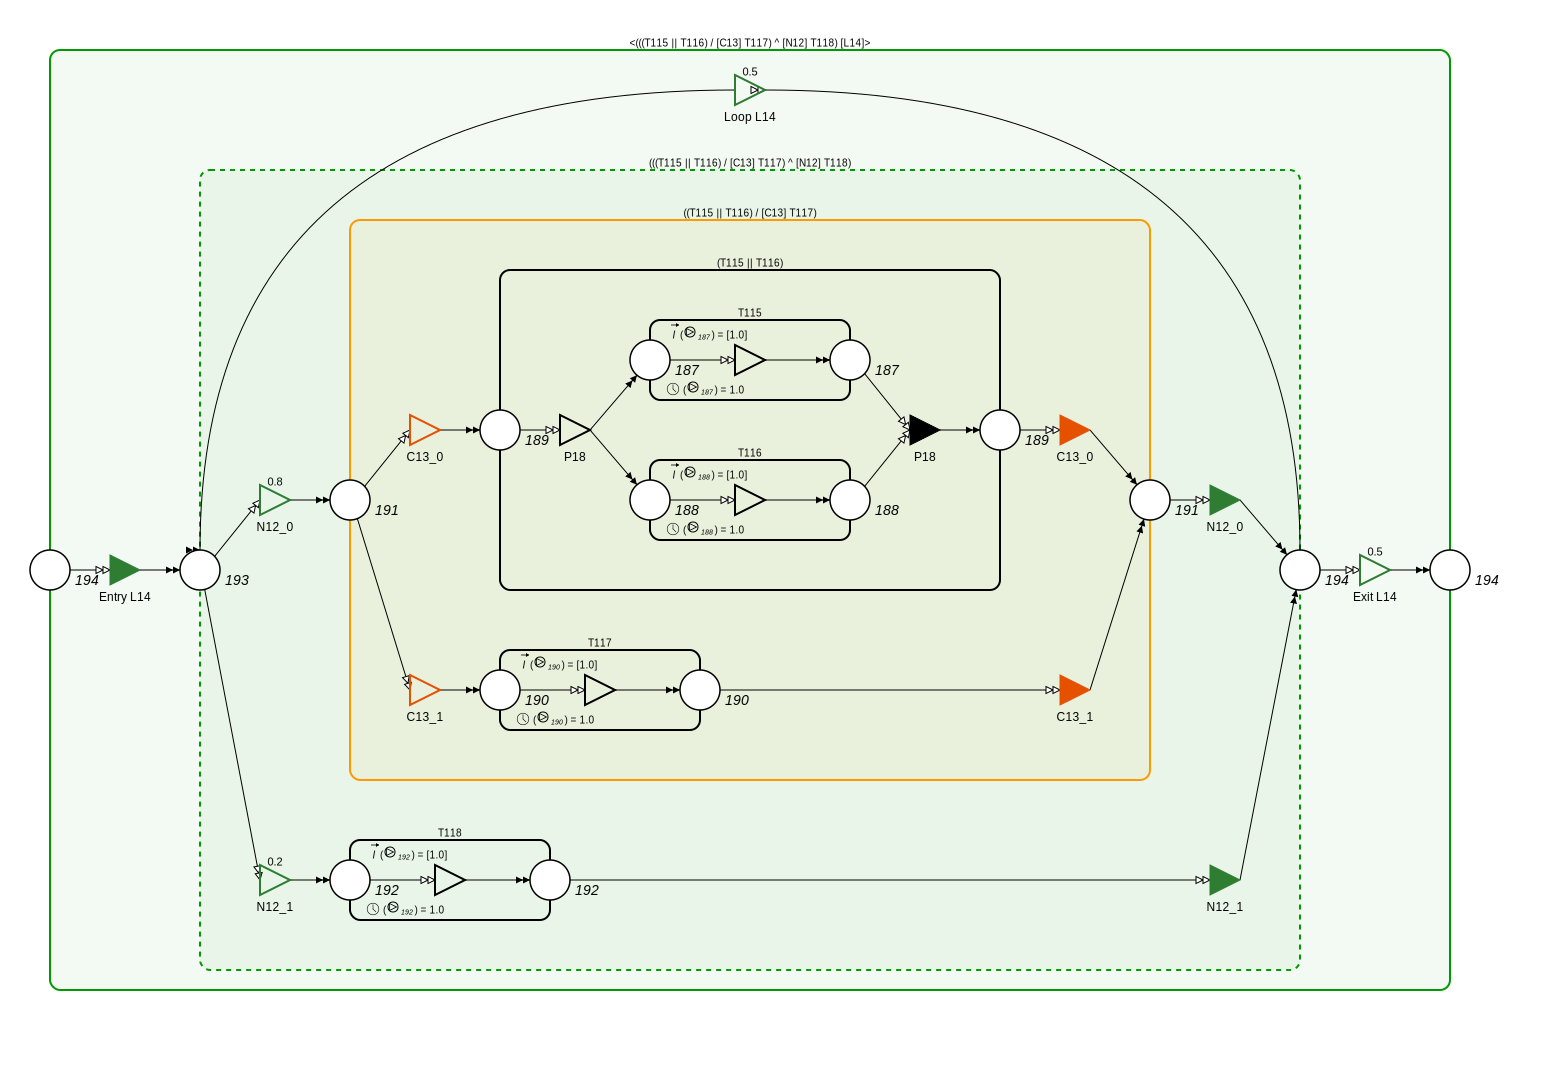

In [57]:
# Expression: < ^[N]( [C]( (T||T), T ), T ) [L] >
region_json = {
    "id": "194",
    "type": "loop",
    "label": "L14",
    "children": [
        {
            "id": "193",
            "type": "nature",
            "label": "N12",
            "children": [
                {
                    "id": "191",
                    "type": "choice",
                    "label": "C13",
                    "children": [
                        {
                            "id": "189",
                            "type": "parallel",
                            "label": "P18",
                            "children": [
                                {
                                    "id": "187",
                                    "type": "task",
                                    "label": "T115",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                },
                                {
                                    "id": "188",
                                    "type": "task",
                                    "label": "T116",
                                    "duration": 1.0,
                                    "impacts": [
                                        1.0
                                    ]
                                }
                            ]
                        },
                        {
                            "id": "190",
                            "type": "task",
                            "label": "T117",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ],
                    "max_delay": 0.0
                },
                {
                    "id": "192",
                    "type": "task",
                    "label": "T118",
                    "duration": 1.0,
                    "impacts": [
                        1.0
                    ]
                }
            ],
            "distribution": [
                0.8,
                0.2
            ]
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))


## Deep Loop Nesting
**Expression**: `L3(L2(L1(T)))`

2026-01-20 13:58:14 - INFO - Starting conversion from BPMN to Petri net


=== BPMN Diagram ===


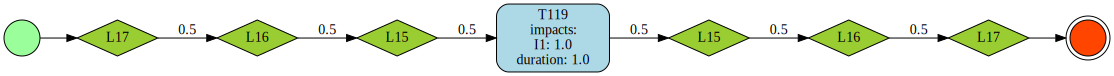


=== Petri Net (PM4PY Standard) ===


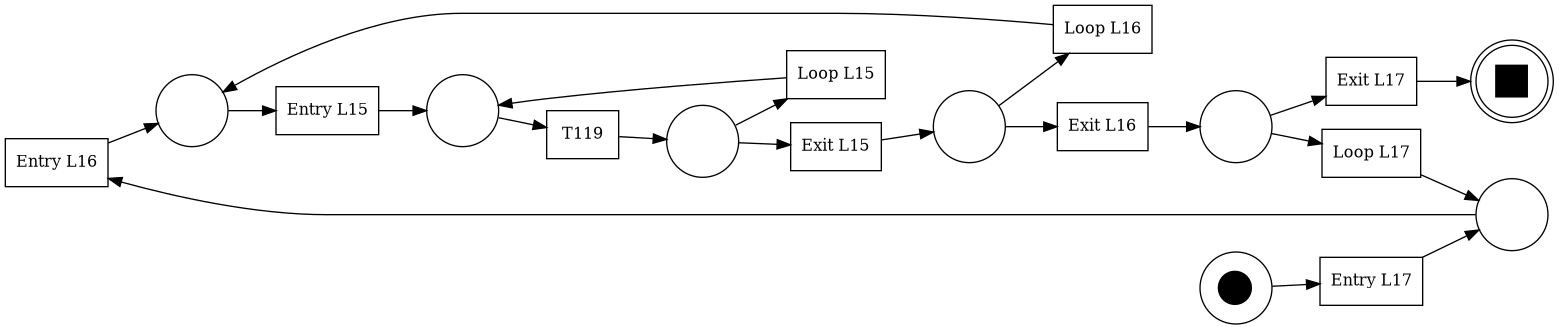


=== SPIN Visualization (Custom SVG) ===


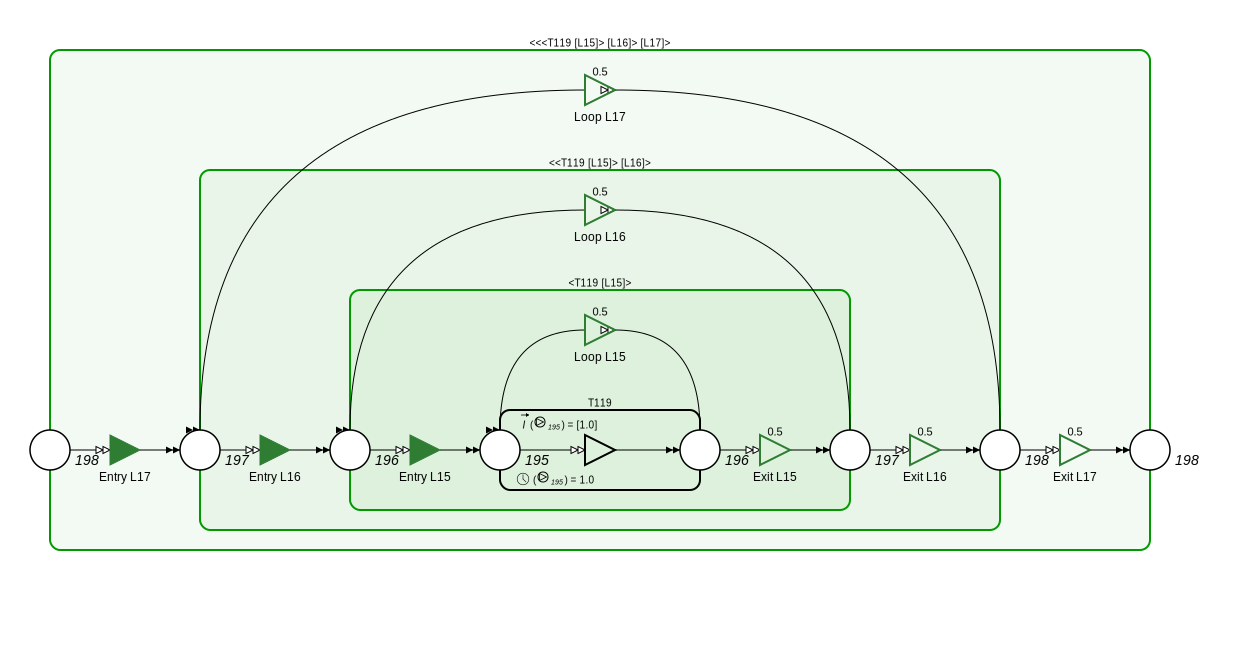

In [58]:
# Expression: L3(L2(L1(T)))
region_json = {
    "id": "198",
    "type": "loop",
    "label": "L17",
    "children": [
        {
            "id": "197",
            "type": "loop",
            "label": "L16",
            "children": [
                {
                    "id": "196",
                    "type": "loop",
                    "label": "L15",
                    "children": [
                        {
                            "id": "195",
                            "type": "task",
                            "label": "T119",
                            "duration": 1.0,
                            "impacts": [
                                1.0
                            ]
                        }
                    ],
                    "distribution": 0.5,
                    "bound": 5
                }
            ],
            "distribution": 0.5,
            "bound": 5
        }
    ],
    "distribution": 0.5,
    "bound": 5
}

# 1. Parse JSON to RegionModel (Pydantic handles Enum conversion)
region_model = RegionModel.model_validate(region_json)

# 2. Convert to Petri Net
net, im, fm = from_region(region_model)

# === VISUALIZATION 1: BPMN DOT ===
print("=== BPMN Diagram ===")
bpmn_dot = wrap_to_dot(region_json, impacts_names=["I1"], active_regions=set())
display(graphviz.Source(bpmn_dot))

# === VISUALIZATION 2: PETRI NET (PM4PY Standard) ===
print("\n=== Petri Net (PM4PY Standard) ===")
# Use PM4PY's visualization - save to temp file and display
import tempfile
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
    pm4py.save_vis_petri_net(net, im.tokens, fm.tokens, tmp.name)
    display(Image(filename=tmp.name))

# === VISUALIZATION 3: SPIN SVG ===
print("\n=== SPIN Visualization (Custom SVG) ===")
svg_out = spin_to_svg(net, width=1000, height=500, region=region_model)
display(SVG(svg_out))
